In [1]:
import numpy as np # mathematical functions
import pandas as pd # data processing
import yfinance as yf # To pull historical data from Yahoo Finance
import matplotlib as mpl
import matplotlib.pyplot as plt # For plotting data and to allow for plots to display in notebook (inline)
%matplotlib inline
mpl.style.use(['ggplot'])
from IPython.display import display # display multiple tables in notebook output
from scipy import stats  #Statistical package
import seaborn as sns # regression plots
from sklearn.linear_model import LinearRegression # Perform linear regression

Se llamará a la API de Yahoo para extraer los datos históricos del S&P500 con el ticker ^GSPC. Estos datos se almacenarán en un dataframe.

In [2]:
#Pull Ticker file with S&P 500 information
tckr = yf.Ticker("^GSPC")

#Pull historical data for S&P 500 and stored in dataframe
data = tckr.history(period="23y")

#Reset index for later processing also allows for dataframe to be queried by date
data.reset_index(inplace=True)

In [ ]:
data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,5786.000000,5786.000000,5786.000000,5786.000000,5.786000e+03,5786.0,5786.0
mean,1899.129922,1910.459935,1886.850493,1899.333463,3.331098e+09,0.0,0.0
std,986.870835,992.143947,981.150702,986.992072,1.516633e+09,0.0,0.0
min,679.280029,695.270020,666.789978,676.530029,3.560700e+08,0.0,0.0
25%,1183.787537,1190.767548,1175.682526,1183.590027,2.083225e+09,0.0,0.0
50%,1440.215027,1449.150024,1430.794983,1439.914978,3.428025e+09,0.0,0.0
75%,2430.385010,2439.480042,2415.159973,2429.250061,4.177535e+09,0.0,0.0
max,4804.509766,4818.620117,4780.040039,4796.560059,1.145623e+10,0.0,0.0


Se crearon dos (2) funciones; uno calculará el cambio porcentual entre dos valores y el otro requerirá resaltar columnas específicas de una tabla. Estas funciones se utilizarán en la sección "Procesamiento de datos" y "Análisis de datos".

In [3]:
#Percent change
def p_chg(x1,x2):
    """
    Esta función calculará el cambio porcentual entre dos valores x1 y x2.
    x1 - Valor inicial
    x2 - Valor final
    La salida se redondeará a dos decimales.
    """
    
    y = ((x2-x1)/x1)*100
    return y

#crear función para resaltar columnas en la tabla
def highlight_cols(s,color):
    return 'background-color: %s' % color

<a id="DataPro"></a>
# **Procesamiento de datos**

Los datos sin procesar se limpiarán en preparación para el análisis y la visualización de datos. Se eliminaron los datos que no eran necesarios para este análisis, se crearon nuevas columnas para el día de la semana, el mes y el año, y se crearon nuevas columnas para el cambio porcentual del precio intradiario, el precio de apertura/cierre y los cambios en el volumen diario.

Las columnas "Dividendo" y "Divisiones de acciones" se eliminarán porque no tienen datos significativos. El ticker del índice no produce un dividendo o división, ya que solo rastrea el índice.

In [4]:
data.drop(columns=['Dividends','Stock Splits'],inplace=True)

Se consultó el dataframe resultante para encontrar las filas que contienen un cero para el valor 'Open'. Esto se señaló como una discrepancia en la sección de preparación de datos.

In [ ]:
# Faltan datos de valor "open" en el dataframe, es necesario averiguar dónde faltan los datos
print("Hay {0:,} filas con valor cero para la columna 'Open'."      
      .format(data[data['Open'] == 0].value_counts().count()))

Hay 0 filas con valor cero para la columna 'Open'.


El dataframe se actualizó para utilizar el valor 'Close' del día anterior si el valor 'Open' es cero. Esto supone que no ha tenido lugar ninguna negociación de mercado ampliada. Según [Investopedia](https://www.investopedia.com/ask/answers/06/preaftermarket.asp#:~:text=The%20New%20York%20Stock%20Exchange%20introduced%20after%2Dmarket%20trading%20in,offered%20more%20hours%20of%20trading.),  después de que se iniciara la negociación en el mercado de la Bolsa de Nueva York en junio de 1991. Según el siguiente código, la última fila con un valor cero 'Open' fue el 19/4/1982.

In [ ]:
data.tail()

,Date,Open,High,Low,Close,Volume
5781,2023-03-20 00:00:00-04:00,3917.469971,3956.620117,3916.889893,3951.570068,5347140000
5782,2023-03-21 00:00:00-04:00,3975.889893,4009.080078,3971.189941,4002.870117,4920240000
5783,2023-03-22 00:00:00-04:00,4002.040039,4039.489990,3936.169922,3936.969971,4533010000
5784,2023-03-23 00:00:00-04:00,3959.209961,4007.659912,3919.050049,3948.719971,4991600000
5785,2023-03-24 00:00:00-04:00,3939.209961,3972.739990,3909.159912,3970.989990,4583970000


In [ ]:
#Itera a través de cada fila de la columna 'Open' del dataframe, si Open == 0, luego cierra desde el día anterior y agrega a la columna Open
#(asumir que no hay comercio de horas extendidas)
index = 0
for value in data['Open']:
    if value == 0:
        data.loc[index,'Open'] = data.loc[index-1,'Close'] 
    index +=1

In [ ]:
#Se asegura de que todas las filas Open tengan valor
print("Hay {0} filas con un valor cero para la columna 'Open'.".format(data[data['Open'] == 0].value_counts().count()))

Hay 0 filas con un valor cero para la columna 'Open'.


In [5]:
#Adicionar nuevas columnas para year, Month, Week, and Weekday
data = data.assign(Year = data['Date'].dt.year, M_num = data['Date'].dt.month, M_nm = data['Date'].dt.month_name(), 
                  D_num = data['Date'].dt.weekday, D_nm = data['Date'].dt.day_name(), Wk = data['Date'].dt.isocalendar().week)

Se crearon nuevas columnas para calcular el cambio porcentual en el valor intraday y el valor de open/close. Estas columnas se calculan utilizando la función "p_chg" creada anteriormente.

In [6]:
data = data.assign(P_intra = p_chg(data['Low'],data['High']),P_day = p_chg(data['Open'],data['Close']))

In [ ]:
#Hay que verificar cuántos cambios porcentuales diarios son 0
print("Hay {0:,} filas (o {1:.2%} del total) donde el cambio porcentual diario es cero. La última entrada donde el cambio de precio diario fue cero fue {2}."
      .format(data[data['P_day'] == 0].value_counts().count(),
              data[data['P_day'] == 0].value_counts().count()/data.value_counts().count(),
              data[data['P_day'] == 0]['Date'].tail(1).iloc[0].date()))

Hay 3 filas (o 0.05% del total) donde el cambio porcentual diario es cero. La última entrada donde el cambio de precio diario fue cero fue 2017-04-10.


Se creó una nueva columna para calcular el cambio en el volumen diario del S&P500. Esta columna se calcula utilizando la función "p_chg" creada anteriormente.

In [7]:
for index in range(0,len(data['Volume'])-1):
    data.loc[index+1,'P_Vol'] = p_chg(data.loc[index,'Volume'],data.loc[index+1,'Volume'])

Se crearon dos nuevas columnas para rastrear los cambios en el valor de cierre del día anterior y el valor de apertura del día siguiente. Una columna calcula los cambios en el precio y la otra calcula el cambio porcentual en el precio basado en el valor de cierre del día anterior. Estas nuevas columnas representan cualquier operación de horario extendido.

In [8]:
#Iterar a través del dataframe, verificando los cambios en el cierre anterior frente a la apertura y calculando la diferencia (si corresponde)
for index in range(0,len(data)-1):  
    if data.loc[index+1,'Open'] != data.loc[index,'Close']:
        data.loc[index+1,'Ex_trd'] = data.loc[index+1,'Open'] - data.loc[index,'Close']
        data.loc[index+1,'PEx_trd'] = p_chg(data.loc[index,'Close'],data.loc[index+1,'Open'])

In [ ]:
print("Hay {0:,} filas en este marco de datos y hay {1:,} filas donde el precio de cierre anterior \
difería del precio de apertura del día siguiente. Eso es aproximadamente {2:.3f}% del total de días de negociación."
      .format(len(data),data["Ex_trd"].count(),data["Ex_trd"].count()/len(data)*100))

Hay 5,786 filas en este marco de datos y hay 4,080 filas donde el precio de cierre anterior difería del precio de apertura del día siguiente. Eso es aproximadamente 70.515% del total de días de negociación.


El conjunto de datos limpio y modificado se guardó en un archivo CSV. Este conjunto de datos se utilizará en el análisis y la visualización.

In [9]:
data.to_csv('Asp500.csv', encoding='utf-8', index=False)

In [ ]:
data.tail()

,Date,Open,High,Low,Close,Volume,Year,M_num,M_nm,D_num,D_nm,Wk,P_intra,P_day,P_Vol,Ex_trd,PEx_trd
5781,2023-03-20 00:00:00-04:00,3917.469971,3956.620117,3916.889893,3951.570068,5347140000,2023,3,March,0,Monday,12,1.014331,0.870462,-42.837503,0.830078,0.021194
5782,2023-03-21 00:00:00-04:00,3975.889893,4009.080078,3971.189941,4002.870117,4920240000,2023,3,March,1,Tuesday,12,0.954126,0.678596,-7.983707,24.319824,0.615447
5783,2023-03-22 00:00:00-04:00,4002.040039,4039.489990,3936.169922,3936.969971,4533010000,2023,3,March,2,Wednesday,12,2.624888,-1.625922,-7.870145,-0.830078,-0.020737
5784,2023-03-23 00:00:00-04:00,3959.209961,4007.659912,3919.050049,3948.719971,4991600000,2023,3,March,3,Thursday,12,2.261004,-0.264952,10.116677,22.239990,0.564901
5785,2023-03-24 00:00:00-04:00,3939.209961,3972.739990,3909.159912,3970.989990,4583970000,2023,3,March,4,Friday,12,1.626438,0.806761,-8.166319,-9.510010,-0.240838


<a id="DataAna"></a>
# **Análisis de los datos**

Esta sección detalla el análisis de datos del conjunto de datos limpio. El objetivo de este análisis es proporcionar un resumen de los datos históricos del S&P 500, destacando las principales tendencias y eventos clave. La primera subsección realiza análisis descriptivos (es decir, máx., media, mediana, etc.) y la segunda subsección proporciona una representación visual de los datos. Tenga en cuenta que se crearon marcos de datos separados para ayudar en el análisis de los datos.

<a id="Sub-1"></a>
## *Análisis descriptivo*

### **Resumen anual**

Se creó un nuevo dataframe para almacenar los datos anuales resumidos del S&P 500. Estos datos incluyen los datos de cierre máximos y mínimos anuales, el valor de cierre anual medio y medio, los datos de apertura y cierre anuales junto con el cambio porcentual anual.

In [10]:
df = data[['Year','Close']]

#Se Extraen los valores máximos y mínimos de cada año, también se capturan los valores anuales de apertura y cierre
yr_max = df.groupby(by = ['Year']).max().rename(columns={'Close': 'Max_close'})
yr_min = df.groupby(['Year']).min().rename(columns={'Close': 'Min_close'})
yr_avg = df.groupby(['Year']).mean().rename(columns={'Close': 'Avg_close'})
yr_med = df.groupby(['Year']).median().rename(columns={'Close': 'Med_close'})
yr_start = df.groupby(['Year']).head(1).rename(columns={'Close': 'Yr_open'})
yr_end = df.groupby(['Year']).tail(1).rename(columns={'Close': 'Yr_end'})

#Se fusionan los datos junto con el año en un nuevo dataframe
yr_df = pd.merge(yr_max,yr_min,how = 'left', on = 'Year')
yr_df = yr_df.merge(yr_avg,how = 'left', on = 'Year')
yr_df = yr_df.merge(yr_med,how = 'left', on = 'Year')
yr_df = yr_df.merge(yr_start,how = 'left', on = 'Year')
yr_df = yr_df.merge(yr_end,how = 'left', on = 'Year')

for index in range(0,len(yr_df)-1):
    yr_df.loc[index+1,'P_yr'] = p_chg(yr_df.loc[index,'Yr_end'],yr_df.loc[index+1,'Yr_end'])   

Las fechas para los valores de cierre máximo y mínimo se agregaron al dataframe.

In [11]:
for year in yr_df['Year']: 
    i = int(yr_df[yr_df["Year"] == year].index.values) 
    for index in range(0,len(data)-1):  
        if int(data.loc[index,'Year']) == int(year): # Si el 'año' de yr_df es igual al 'año' de los datos df, buscar el valor que coincide
            if float(data.loc[index,'Close']) == float(yr_df.loc[i,'Max_close']): 
                yr_df.loc[i,"Max_date"] = data.loc[index,"Date"]
            elif float(data.loc[index,'Close']) == float(yr_df.loc[i,'Min_close']):
                yr_df.loc[i,"Min_date"] = data.loc[index,"Date"]
        else:
            continue

Los datos anuales resumidos se guardaron en un archivo csv.

In [ ]:
yr_df.tail()

,Year,Max_close,Min_close,Avg_close,Med_close,Yr_open,Yr_end,P_yr,Max_date,Min_date
19,2019,3240.020020,2447.889893,2913.356380,2919.024902,2510.030029,3230.780029,28.878070,2019-12-27 00:00:00-05:00,2019-01-03 00:00:00-05:00
20,2020,3756.070068,2237.399902,3217.855849,3276.020020,3257.850098,3756.070068,16.258923,2020-12-31 00:00:00-05:00,2020-03-23 00:00:00-04:00
21,2021,4793.060059,3700.649902,4273.385635,4304.000000,3700.649902,4766.180176,26.892739,2021-12-29 00:00:00-05:00,2021-01-04 00:00:00-05:00
22,2022,4796.560059,3577.030029,4098.514748,4027.260010,4796.560059,3839.500000,-19.442827,2022-01-03 00:00:00-05:00,2022-10-12 00:00:00-04:00
23,2023,4179.759766,3808.100098,3997.671061,3990.969971,3824.139893,3970.989990,3.424664,2023-02-02 00:00:00-05:00,2023-01-05 00:00:00-05:00


In [12]:
yr_df.to_csv('Resumen_anual.csv', encoding='utf-8', index=False)

### **Resumen mensual**

Se creó un nuevo dataframe para almacenar los datos mensuales resumidos del S&P 500. Estos datos incluyen el máximo, el mínimo, el promedio y la desviación estándar mensuales para los valores de cierre diarios y los valores intradiarios.

In [13]:
df = data[['M_nm','P_day', 'P_intra']] 

#Se Extraen los valores máximo, mínimo, medio y desviación estándar de cada mes
mnth_max = df.groupby(by = ['M_nm'], sort=False).max().rename(columns={'P_day': 'Max_P_day','P_intra': 'Max_P_intra'})
mnth_min = df.groupby(by = ['M_nm'], sort=False).min().rename(columns={'P_day': 'Min_P_day','P_intra': 'Min_P_intra'})
mnth_avg = df.groupby(['M_nm'], sort=False).mean().rename(columns={'P_day': 'Avg_P_day','P_intra': 'Avg_P_intra'})
mnth_std = df.groupby(['M_nm'], sort=False).std().rename(columns={'P_day': 'Std_P_day','P_intra': 'Std_P_intra'})

#Se Fusionan los datos junto con el mes en un nuevo dataframe
mnth_df = pd.merge(mnth_max, mnth_min, on = "M_nm")
mnth_df = mnth_df.merge(mnth_avg, on = 'M_nm')
mnth_df = mnth_df.merge(mnth_std, on = 'M_nm')

mnth_df.reset_index(inplace=True)
mnth_df

,M_nm,Max_P_day,Max_P_intra,Min_P_day,Min_P_intra,Avg_P_day,Avg_P_intra,Std_P_day,Std_P_intra
0,March,6.553066,8.785210,-5.709928,0.249097,0.047769,1.541089,1.326877,1.270415
1,April,4.367998,7.768931,-5.827794,0.282857,0.054065,1.306673,1.060721,0.887023
2,May,3.750392,9.550654,-3.228457,0.185722,0.025369,1.287646,0.975203,0.819872
3,June,2.869144,4.135371,-3.887586,0.214844,-0.046544,1.247174,0.964878,0.685285
4,July,5.731402,8.849012,-3.835246,0.207347,0.057982,1.240402,1.010246,0.864099
5,August,4.668689,7.075973,-6.593353,0.169258,0.010129,1.237381,1.087165,0.929009
6,September,4.720856,9.277661,-8.489989,0.185769,-0.081114,1.362091,1.217835,1.037716
7,October,10.789006,11.497976,-8.723100,0.173467,0.056372,1.610068,1.466060,1.553473
8,November,6.817246,11.520845,-6.630101,0.145747,0.066362,1.328452,1.239967,1.200638
9,December,4.778948,8.939669,-8.147552,0.170064,0.004282,1.201910,1.044559,0.974072


In [14]:
mnth_df.to_csv('Resumen_mensual.csv', encoding='utf-8', index=False)

Según la tabla anterior, parece que el mes de octubre tiene una variación diaria de precios significativamente mayor en comparación con los otros meses. Se consultó el dataframe limpio para encontrar las fechas de los cambios de precios máximos y mínimos en octubre.

In [ ]:
print("El cambio de precio diario máximo de octubre de {0:.3f}% ocurrió el {1}. El cambio de precio diario mínimo de octubre de {2:.3f}% ocurrió el {3}."
     .format(data[(data['P_day'] == data['P_day'].max()) & (data['M_nm'] == "October")]['P_day'].iloc[0], 
             data[(data['P_day'] == data['P_day'].max()) & (data['M_nm'] == "October")]['Date'].iloc[0].date(),
             data[(data['P_day'] == data['P_day'].min()) & (data['M_nm'] == "October")]['P_day'].iloc[0], 
             data[(data['P_day'] == data['P_day'].min()) & (data['M_nm'] == "October")]['Date'].iloc[0].date()))

El cambio de precio diario máximo de octubre de 10.789% ocurrió el 2008-10-28. El cambio de precio diario mínimo de octubre de -8.723% ocurrió el 2008-10-15.


Se creó un nuevo dataframe para eliminar estos valores y determinar su efecto en los valores de octubre.

In [ ]:
# Se Eliminan los datos de Black Friday y 2008 GFC de mnth_df
# y se encuentra el valor del índice tanto para el máximo como para el mínimo de octubre
mth_max = data[(data['P_day'] == data['P_day'].max()) & (data['M_nm'] == "October")].index[0]
mth_min =data[(data['P_day'] == data['P_day'].min()) & (data['M_nm'] == "October")].index[0]

data2 = data.drop(labels = [mth_min, mth_max], axis = 0) 

df = data2[['M_nm','P_day', 'P_intra']] #hago copia en otro dataframe

#Extraiga los valores máximo, mínimo, medio y desviación estándar de cada mes
mnth_max = df.groupby(by = ['M_nm'], sort=False).max().rename(columns={'P_day': 'Max_P_day','P_intra': 'Max_P_intra'})
mnth_min = df.groupby(by = ['M_nm'], sort=False).min().rename(columns={'P_day': 'Min_P_day','P_intra': 'Min_P_intra'})
mnth_avg = df.groupby(['M_nm'], sort=False).mean().rename(columns={'P_day': 'Avg_P_day','P_intra': 'Avg_P_intra'})
mnth_std = df.groupby(['M_nm'], sort=False).std().rename(columns={'P_day': 'Std_P_day','P_intra': 'Std_P_intra'})

#Fusionar los datos junto con el mes en un nuevo dataframe
mnth2_df = pd.merge(mnth_max, mnth_min, on = "M_nm")
mnth2_df = mnth2_df.merge(mnth_avg, on = 'M_nm')
mnth2_df = mnth2_df.merge(mnth_std, on = 'M_nm')

mnth2_df.reset_index(inplace=True)

Las filas del mes de octubre del dataframe original y el modificado se combinaron en una tabla. Después de eliminar las dos filas, los valores mensuales están más en línea con los meses restantes, aunque aún son elevados: la desviación estándar para los cambios de precios aún está por encima del 1%, que es el único mes en que esto ocurre.

In [ ]:
pd.concat([mnth_df[mnth_df['M_nm'] == 'October'], mnth2_df[mnth2_df['M_nm'] == 'October']], keys=['Original','Oct Max/Min Removed'])

,,M_nm,Max_P_day,Max_P_intra,Min_P_day,Min_P_intra,Avg_P_day,Avg_P_intra,Std_P_day,Std_P_intra
Original,7,October,10.789006,11.497976,-8.723100,0.173467,0.056372,1.610068,1.466060,1.553473
Oct Max/Min Removed,7,October,9.926045,11.497976,-7.941968,0.173467,0.052504,1.574285,1.332802,1.447785


Se creó otro dataframe para capturar los valores de apertura y cierre de cada año y mes, respectivamente. Además, se calcularon los valores de cierre promedio y mediano y se calculó el cambio porcentual mensual. El dataframe se utilizará en la sección de resumen de estadísticas.

In [ ]:
df = data[['Year','M_nm', 'Close']]

#Se Extraen los valores de desviación estándar, inicial, final y media de cada mes para cada año
m_start = df.groupby(['Year','M_nm']).head(1).rename(columns={'Close': 'M_open'})
m_end = df.groupby(['Year','M_nm']).tail(1).rename(columns={'Close': 'M_end'})
m_avg = df.groupby(['Year','M_nm'],sort = False, as_index = False).mean().rename(columns={'Close': 'M_avg'})
m_med = df.groupby(['Year','M_nm'],sort = False,as_index = False).median().rename(columns={'Close': 'M_median'})

#Combine los datos junto con el año/mes en un nuevo dataframe
m_df = pd.merge(m_start, m_end)
m_df = m_df.merge(m_avg)
m_df = m_df.merge(m_med)

for index in range(0,len(m_df)-1): #Calculo el cambio porcentual mensual
    m_df.loc[index,'P_mnth'] = p_chg(m_df.loc[index,'M_open'],m_df.loc[index,'M_end'])

### **Resumen semanal**

Se creó un nuevo dataframe para almacenar los datos semanales resumidos del S&P 500. Estos datos incluyen el máximo diario, el mínimo, el promedio y la desviación estándar para los valores de cierre diarios y los valores intradiarios.

In [15]:
df = data[['Wk','P_day','P_intra']]

#Se Extraen los valores máximo, mínimo, medio y desviación estándar de cada semana
wk_max = df.groupby(by = ['Wk'], sort=False).max().rename(columns={'P_day': 'Max_P_day','P_intra': 'Max_P_intra'})
wk_min = df.groupby(by = ['Wk'], sort=False).min().rename(columns={'P_day': 'Min_P_day','P_intra': 'Min_P_intra'})
wk_avg = df.groupby(['Wk'], sort=False).mean().rename(columns={'P_day': 'Avg_P_day','P_intra': 'Avg_P_intra'})
wk_std = df.groupby(['Wk'], sort=False).std().rename(columns={'P_day': 'Std_P_day','P_intra': 'Std_P_intra'})

#Se Fusionan los datos junto con la semana en un nuevo dataframe
wk_df = pd.merge(wk_max,wk_min,on='Wk')
wk_df = wk_df.merge(wk_avg,on='Wk')
wk_df = wk_df.merge(wk_std,on='Wk')

wk_df.reset_index(inplace=True)

In [16]:
wk_df.to_csv('Resumen_semanal.csv', encoding='utf-8', index=False)

Se creó otro dataframe para capturar los valores de apertura y cierre de cada año y semana, respectivamente. Además, se calcularon los valores de cierre promedio y mediano y se calculó el cambio porcentual semanal. El dataframe se utilizará en la sección de resumen de estadísticas.

In [18]:
df = data[['Year','Wk', 'Close']]

#Se Extraen los valores de desviación estándar, inicial, final y media de cada semana
w_start = df.groupby(['Year','Wk']).head(1).rename(columns={'Close': 'Wk_open'})
w_end = df.groupby(['Year','Wk']).tail(1).rename(columns={'Close': 'Wk_end'})
w_avg = df.groupby(['Year','Wk'],sort = False,as_index = False).mean().rename(columns={'Close': 'Wk_avg'})
w_med = df.groupby(['Year','Wk'],sort = False,as_index = False).median().rename(columns={'Close': 'Wk_median'})

#Se Combinan los datos junto con la semana/año en un nuevo dataframe
w_df = pd.merge(w_start, w_end)
w_df = w_df.merge(w_avg)
w_df = w_df.merge(w_med)

for index in range(0,len(w_df)-1): #Se Calcula el cambio porcentual mensual
    w_df.loc[index,'P_wk'] = p_chg(w_df.loc[index,'Wk_open'],w_df.loc[index,'Wk_end'])

### **Resumen diario**

Se creó un nuevo dataframe para almacenar los datos resumidos del S&P 500 de los días laborables. Estos datos incluyen el máximo diario, el mínimo, el promedio y la desviación estándar para los valores de cierre diarios y los valores intradiarios.

In [21]:
df = data[['D_nm','P_day','P_intra']]

#Se Extraen los valores máximo, mínimo, medio y desviación estándar de cada día de la semanad_max = df.groupby(by = ['D_nm'], sort=False).max().rename(columns={'P_day': 'Max_P_day','P_intra': 'Max_P_intra'})
d_min = df.groupby(by = ['D_nm'], sort=False).min().rename(columns={'P_day': 'Min_P_day','P_intra': 'Min_P_intra'})
d_avg = df.groupby(['D_nm'], sort=False).mean().rename(columns={'P_day': 'Avg_P_day','P_intra': 'Avg_P_intra'})
d_std = df.groupby(['D_nm'], sort=False).std().rename(columns={'P_day': 'Std_P_day','P_intra': 'Std_P_intra'})

#Se Fusionan los datos junto con el día de la semana en un nuevo dataframe
dy_df = pd.merge(d_max,d_min,on='D_nm')
dy_df = dy_df.merge(d_avg,on='D_nm')
dy_df = dy_df.merge(d_std,on='D_nm')

index_dy = ['Monday','Tuesday','Wednesday','Thursday','Friday'] # Reordena el indice

dy_df = dy_df.reindex(index_dy)
dy_df.reset_index(inplace=True)
dy_df

,D_nm,Max_P_day,Max_P_intra,Min_P_day,Min_P_intra,Avg_P_day,Avg_P_intra,Std_P_day,Std_P_intra
0,Monday,9.926045,10.318268,-8.489989,0.170064,-0.006745,1.298198,1.203189,1.070579
1,Tuesday,10.789006,11.267404,-5.802761,0.178495,0.037680,1.322917,1.152789,0.995718
2,Wednesday,5.731402,8.849012,-8.723100,0.173467,0.015623,1.362113,1.121042,1.012516
3,Thursday,6.817246,11.520845,-7.941968,0.185261,0.039414,1.388814,1.156121,1.094314
4,Friday,5.846476,11.497976,-5.827794,0.145747,-0.005763,1.301349,1.034625,0.990892


In [22]:
dy_df.to_csv('Resumen_diario.csv', encoding='utf-8', index=False)

Tenga en cuenta que la desviación estándar para el 'Monday' es significativamente más alta que la de los días restantes de la semana. Esto podría deberse potencialmente al gran valor mínimo de -20,46%. A partir del análisis del mes anterior, sabemos cuándo se produjo la caída de este precio. Este valor será eliminado para determinar su efecto.

In [20]:
dy_min =data[(data['P_day'] == data['P_day'].min()) & (data['M_nm'] == "October")].index[0] # find index value for row

data2 = data.drop(labels = [dy_min], axis = 0)

df = data2[['D_nm','P_day','P_intra']] #crear nuevo df con filas eliminadas

#Se Extraen los valores máximo, mínimo, medio y desviación estándar de cada día de la semana
d_max = df.groupby(by = ['D_nm'], sort=False).max().rename(columns={'P_day': 'Max_P_day','P_intra': 'Max_P_intra'})
d_min = df.groupby(by = ['D_nm'], sort=False).min().rename(columns={'P_day': 'Min_P_day','P_intra': 'Min_P_intra'})
d_avg = df.groupby(['D_nm'], sort=False).mean().rename(columns={'P_day': 'Avg_P_day','P_intra': 'Avg_P_intra'})
d_std = df.groupby(['D_nm'], sort=False).std().rename(columns={'P_day': 'Std_P_day','P_intra': 'Std_P_intra'})

#Se Fusionan los datos junto con el día de la semana en un nuevo dataframe
dy_df2 = pd.merge(d_max,d_min,on='D_nm')
dy_df2 = dy_df2.merge(d_avg,on='D_nm')
dy_df2 = dy_df2.merge(d_std,on='D_nm')

index_dy = ['Monday','Tuesday','Wednesday','Thursday','Friday'] # Reordenar el indice

dy_df2 = dy_df2.reindex(index_dy)
dy_df2.reset_index(inplace=True)

Al eliminar el datapoint más bajo, vemos una ligera disminución en la desviación estándar diaria del precio. La variación del precio diario del lunes sigue siendo elevada en comparación con el resto de los días de la semana. Ha habido cuatro (4) ['Black Mondays'](https://www.thebalance.com/what-is-black-monday-in-1987-1929-and-2015-3305818) que han resultado en una gran cantidad de existencias. caídas del mercado.

In [ ]:
pd.concat([dy_df.iloc[0:1,:],dy_df2.iloc[0:1,:]],keys = ['Original','Excluded Min Value'])

,,D_nm,Max_P_day,Max_P_intra,Min_P_day,Min_P_intra,Avg_P_day,Avg_P_intra,Std_P_day,Std_P_intra
Original,0,Monday,9.926045,10.318268,-8.489989,0.170064,-0.006837,1.298405,1.203203,1.070512
Excluded Min Value,0,Monday,9.926045,10.318268,-8.489989,0.170064,-0.006837,1.298405,1.203203,1.070512


<a id="Sub-1a"></a>
### **Resumen estadístico**

In [ ]:
print(f"El rendimiento porcentual promedio diario es {data['P_day'].mean():.3%}.")

El rendimiento porcentual promedio diario es 1.627%.


La cantidad de cambios de precios diarios superiores al 1% se calcula a continuación.

In [ ]:
df = data[['M_nm','P_day']] #tirar filas de data df en nuevos df
#contar cambios porcentuales y agrupar por mes
g_1 = df.groupby(by=["M_nm"],sort = False).apply(lambda x: x[(x['P_day'] >= 1) & 
                                                             (x['P_day'] < 2.5)].count()).drop(['M_nm'], axis =1).rename(columns={'P_day':'Chg > 1%'})
g_25 = df.groupby(by=["M_nm"],sort = False).apply(lambda x: x[(x['P_day'] >= 2.5) & 
                                                              (x['P_day'] < 5)].count()).drop(['M_nm'], axis =1).rename(columns={'P_day':'Chg > 2.5%'})
g_5 = df.groupby(by=["M_nm"],sort = False).apply(lambda x: x[(x['P_day'] >= 5) & 
                                                             (x['P_day'] < 10)].count()).drop(['M_nm'], axis =1).rename(columns={'P_day':'Chg > 5%'})
g_10 = df.groupby(by=["M_nm"],sort = False).apply(lambda x: x[x['P_day'] >= 10].count()).drop(['M_nm'], axis =1).rename(columns={'P_day':'Chg > 10%'})

chg = pd.merge(g_1,g_25, on = 'M_nm')
chg = chg.merge(g_5, on = 'M_nm')
chg = chg.merge(g_10, on = 'M_nm')

chg.loc["Sum",:] = [g_1.sum(axis=0)[0], g_25.sum(axis=0)[0], g_5.sum(axis=0)[0], g_10.sum(axis=0)[0]]
chg.reset_index(inplace=True)
chg

,Chg > 1%,Chg > 2.5%,Chg > 5%,Chg > 10%
M_nm,,,,
March,58.0,12.0,4.0,0.0
April,48.0,11.0,0.0,0.0
May,52.0,9.0,0.0,0.0
June,51.0,2.0,0.0,0.0
July,55.0,3.0,2.0,0.0
August,47.0,8.0,0.0,0.0
September,48.0,7.0,0.0,0.0
October,69.0,12.0,1.0,1.0
November,47.0,9.0,3.0,0.0


In [ ]:
print('Fuera de {0:,} días de negociación, solo {1:,} días (o {2:.3%}), han tenido cambios de precios diarios superiores al 1%, y fuera de eso {1:,} días, solo {3} días (o {4:.3%} \
del total de días de negociación) han tenido cambios de precio diarios superiores al 2.5%.'.format(data['Date'].count(),
                                                       data[(data['P_day'] >=1)].value_counts().count(),
                                                       (data[(data['P_day'] >=1)].value_counts().count())/data['Date'].count(),
                                                       data[(data['P_day'] >=2.5)].value_counts().count(),
                                                       (data[(data['P_day'] >=2.5)].value_counts().count())/data['Date'].count()))

Fuera de 5,786 días de negociación, solo 480 días (o 8.296%), han tenido cambios de precios diarios superiores al 1%, y fuera de eso 480 días, solo 68 días (o 1.175% del total de días de negociación) han tenido cambios de precio diarios superiores al 2.5%.


In [ ]:
print(f"El porcentaje promedio del precio intradiario es {data['P_intra'].mean():.3%}.")

El porcentaje promedio del precio intradiario es 133.545%.


In [ ]:
#Ubicación del índice para el valor máximo
max = data.loc[data['P_day'] == data['P_day'].max()]

print(f"El porcentaje promedio del precio intradiario es {data['P_intra'].mean():.3%}, que ocurrió el {max.iloc[0,0]:%Y-%m-%d}" )

El porcentaje promedio del precio intradiario es 133.545%, que ocurrió el 2008-10-28


In [ ]:
#Ubicación del índice para el valor mínimo
min = data.loc[data['P_day'] == data['P_day'].min()]

print(f"La pérdida de precio máxima diaria fue {data['P_day'].min():.3%}, que ocurrió el {min.iloc[0,0]:%Y-%m-%d}" )

La pérdida de precio máxima diaria fue -872.310%, que ocurrió el 2008-10-15


### ¿Cuáles son las 10 principales ganancias y pérdidas diarias del S&P 500?

In [ ]:
print("Las 10 principales ganancias diarias son: \n")
ganancias_diarias=data.sort_values(by=['P_day','Date'],ascending=False).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Volume','Year','M_num','D_num','Ex_trd','PEx_trd','P_Vol'], axis = 1)
ganancias_diarias

Las 10 principales ganancias diarias son: 



,Date,Open,High,Low,Close,M_nm,D_nm,Wk,P_intra,P_day
1,2008-10-28 00:00:00-04:00,848.919983,940.510010,845.270020,940.510010,October,Tuesday,44,11.267404,10.789006
2,2008-10-13 00:00:00-04:00,912.750000,1006.929993,912.750000,1003.349976,October,Monday,42,10.318268,9.926045
3,2008-11-13 00:00:00-05:00,853.130005,913.010010,818.690002,911.289978,November,Thursday,46,11.520845,6.817246
4,2009-03-23 00:00:00-04:00,772.309998,823.369995,772.309998,822.919983,March,Monday,13,6.611335,6.553066
5,2008-11-24 00:00:00-05:00,801.200012,865.599976,801.200012,851.809998,November,Monday,48,8.037938,6.316773
6,2009-03-10 00:00:00-04:00,679.280029,719.599976,679.280029,719.599976,March,Tuesday,11,5.935688,5.935688
7,2008-11-21 00:00:00-05:00,755.840027,801.200012,741.020020,800.030029,November,Friday,47,8.121237,5.846476
8,2002-07-24 00:00:00-04:00,797.710022,844.320007,775.679993,843.429993,July,Wednesday,30,8.849012,5.731402
9,2020-03-13 00:00:00-04:00,2569.989990,2711.330078,2492.370117,2711.020020,March,Friday,11,8.785210,5.487571
10,2002-07-29 00:00:00-04:00,852.840027,898.960022,852.840027,898.960022,July,Monday,31,5.407813,5.407813


In [ ]:
print("Las 10 principales pérdidas diarias son: \n")
pérdidas_diarias=data.sort_values(by=['P_day','Date']).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Volume','Year','M_num','D_num','Ex_trd','PEx_trd','P_Vol'], axis = 1)
pérdidas_diarias

Las 10 principales pérdidas diarias son: 



,Date,Open,High,Low,Close,M_nm,D_nm,Wk,P_intra,P_day
1,2008-10-15 00:00:00-04:00,994.599976,994.599976,903.989990,907.840027,October,Wednesday,42,10.023339,-8.723100
2,2008-09-29 00:00:00-04:00,1209.069946,1209.069946,1106.420044,1106.420044,September,Monday,40,9.277661,-8.489989
3,2008-12-01 00:00:00-05:00,888.609985,888.609985,815.690002,816.210022,December,Monday,49,8.939669,-8.147552
4,2008-10-09 00:00:00-04:00,988.419983,1005.250000,909.190002,909.919983,October,Thursday,41,10.565448,-7.941968
5,2008-11-20 00:00:00-05:00,805.869995,820.520020,747.780029,752.440002,November,Thursday,47,9.727458,-6.630101
6,2011-08-08 00:00:00-04:00,1198.479980,1198.479980,1119.280029,1119.459961,August,Monday,32,7.075973,-6.593353
7,2008-11-19 00:00:00-05:00,859.030029,864.570007,806.179993,806.580017,November,Wednesday,47,7.242801,-6.105725
8,2000-04-14 00:00:00-04:00,1440.510010,1440.510010,1339.400024,1356.560059,April,Friday,15,7.548901,-5.827794
9,2008-10-07 00:00:00-04:00,1057.599976,1072.910034,996.229980,996.229980,October,Tuesday,41,7.697023,-5.802761
10,2008-10-22 00:00:00-04:00,951.669983,951.669983,875.809998,896.780029,October,Wednesday,43,8.661694,-5.767751


De los 20 puntos de datos mencionados anteriormente, 11 ganancias/pérdidas diarias de precios ocurrieron durante la [2007-2009 Global Financial Crisis (también conocida como la Gran Recesión)](https://www.federalreservehistory.org/essays/great-recession-and-its-aftermath) con siete (7) de las mayores ganancias y cuatro (4) de las mayores pérdidas ocurriendo durante este tiempo. Siete (7) de las 10 mayores pérdidas diarias del S&P 500 ocurrieron el lunes y cinco (5) de las mayores pérdidas diarias ocurrieron en octubre.

Tenga en cuenta que es poco probable que ocurra otra caída diaria del precio del -20 % ya que [circuit breakers](https://www.investor.gov/introduction-investing/investing-basics/glossary/stock-market-circuit-breakers) fueron establecido después de la caída del mercado de 1987 para detener el comercio una vez que se alcanzan ciertos umbrales de precios intradía.

#### ¿Cuáles son los 10 principales movimientos intradía del S&P 500?

In [ ]:
print("Los 10 principales movimientos intradiarios son: \n")
movimientos_intradiarios=data.sort_values(by=['P_intra','Date'], ascending=False).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Volume','Year','M_num','D_num','Ex_trd','PEx_trd','P_Vol'], axis = 1)
movimientos_intradiarios

Los 10 principales movimientos intradiarios son: 



,Date,Open,High,Low,Close,M_nm,D_nm,Wk,P_intra,P_day
1,2008-11-13 00:00:00-05:00,853.130005,913.010010,818.690002,911.289978,November,Thursday,46,11.520845,6.817246
2,2008-10-10 00:00:00-04:00,902.309998,936.359985,839.799988,899.219971,October,Friday,41,11.497976,-0.342457
3,2008-10-28 00:00:00-04:00,848.919983,940.510010,845.270020,940.510010,October,Tuesday,44,11.267404,10.789006
4,2008-10-09 00:00:00-04:00,988.419983,1005.250000,909.190002,909.919983,October,Thursday,41,10.565448,-7.941968
5,2008-10-13 00:00:00-04:00,912.750000,1006.929993,912.750000,1003.349976,October,Monday,42,10.318268,9.926045
6,2008-10-15 00:00:00-04:00,994.599976,994.599976,903.989990,907.840027,October,Wednesday,42,10.023339,-8.723100
7,2008-11-20 00:00:00-05:00,805.869995,820.520020,747.780029,752.440002,November,Thursday,47,9.727458,-6.630101
8,2010-05-06 00:00:00-04:00,1164.380005,1167.579956,1065.790039,1128.150024,May,Thursday,18,9.550654,-3.111525
9,2008-10-16 00:00:00-04:00,909.530029,947.710022,865.830017,946.429993,October,Thursday,42,9.456822,4.057036
10,2008-09-29 00:00:00-04:00,1209.069946,1209.069946,1106.420044,1106.420044,September,Monday,40,9.277661,-8.489989


Siete (7) de los diez (10) mayores movimientos de precios intradiarios ocurrieron durante la crisis financiera mundial de 2007-2009, otros dos (2) ocurrieron durante el [1987 Market Crash](https://www.federalreservehistory.org/essays/stock-market-crash-of-1987). Los grandes movimientos intradiarios no necesariamente indican una ganancia diaria positiva o negativa.

#### ¿Cuáles son las 10 principales ganancias y pérdidas semanales del S&P 500?

In [ ]:
print("Las 10 principales ganancias semanales son: \n")
ganancias_semanales=w_df.sort_values(by=['P_wk'],ascending=False).head(11).reset_index(drop=True).shift()[1:]
ganancias_semanales

Las 10 principales ganancias semanales son: 



,Year,Wk,Wk_open,Wk_end,Wk_avg,Wk_median,P_wk
1,2019.0,1,2510.030029,3230.780029,2788.385986,2531.939941,28.714796
2,2013.0,1,1462.420044,1848.359985,1615.537988,1466.469971,26.390499
3,2003.0,1,909.030029,1111.920044,1029.732019,1109.479980,22.319396
4,2008.0,44,848.919983,968.750000,928.472009,940.510010,14.115584
5,2020.0,13,2237.399902,2541.469971,2466.366016,2475.560059,13.590332
6,2014.0,1,1831.979980,2058.899902,1978.634009,2058.899902,12.386594
7,2009.0,11,676.530029,756.549988,724.955994,721.359985,11.827998
8,2012.0,1,1277.060059,1426.189941,1307.884033,1277.810059,11.677594
9,2002.0,32,834.599976,908.640015,877.008008,876.770020,8.871321
10,2008.0,49,816.210022,876.070007,851.409998,848.809998,7.333895


In [ ]:
print("Las 10 principales pérdidas semanales son: \n")
pérdidas_semanales=w_df.sort_values(by=['P_wk']).head(11).reset_index(drop=True).shift()[1:]
pérdidas_semanales

Las 10 principales pérdidas semanales son: 



,Year,Wk,Wk_open,Wk_end,Wk_avg,Wk_median,P_wk
1,2008.0,1,1447.160034,903.250000,1161.543345,1157.440002,-37.584650
2,2002.0,1,1154.670044,879.820007,1050.332019,1154.670044,-23.803340
3,2008.0,41,1056.890015,899.219971,969.439990,984.940002,-14.918302
4,2008.0,43,985.400024,876.770020,924.422009,908.109985,-11.023950
5,2001.0,1,1283.270020,1148.079956,1282.119995,1298.349976,-10.534810
6,2000.0,15,1504.459961,1356.560059,1453.858008,1467.170044,-9.830764
7,2020.0,9,3225.889893,2954.219971,3080.693945,3116.389893,-8.421550
8,2002.0,29,917.929993,847.750000,890.843994,900.940002,-7.645462
9,2010.0,18,1202.260010,1110.880005,1156.152002,1165.869995,-7.600686
10,2001.0,38,1038.770020,965.799988,1007.589990,1016.099976,-7.024657


Los movimientos semanales más grandes tienden a ocurrir a principios de año, esto podría deberse potencialmente al [January Effect](https://www.fool.com/investing/how-to-invest/stocks/january-effect/). Aunque la primera semana del año contiene la mayoría de los principales ganadores y perdedores semanales, esto no se correlaciona con las 10 ganancias/pérdidas diarias máximas/mínimas ni con los movimientos intradiarios.

Dado que la primera semana del año tiende a ver el movimiento más semanal, ¿estos movimientos de precios marcan la pauta para el año?

In [ ]:
#Se Extraen los valores del año de las 10 mejores semanas df
gainers = w_df.sort_values(by=['P_wk'],ascending=False).head(10)['Year'].values
losers = w_df.sort_values(by=['P_wk']).head(10)['Year'].values
#Se Extraen los datos de ganancias anuales del año df en función del año de la lista de los 10 principales de la semana 
# y se eliminan las filas innecesarias
gain = yr_df[yr_df['Year'].isin(gainers)].drop(['Max_close','Min_close','Avg_close','Med_close','Min_date','Max_date'], 
                                               axis =1).reindex(columns = ['Year','P_yr','Yr_open','Yr_end'])
lose = yr_df[yr_df['Year'].isin(losers)].drop(['Max_close','Min_close','Avg_close','Med_close','Min_date','Max_date'],
                                              axis =1).reindex(columns = ['Year','P_yr','Yr_open','Yr_end'])
#Crear df para ganadores/perdedores semanales
wk_g = w_df.sort_values(by=['P_wk'],ascending=False).head(11).drop(['Wk_avg','Wk_median'],
                                                                   axis=1).reset_index(drop=True).shift()[1:]
wk_l = w_df.sort_values(by=['P_wk']).head(11).drop(['Wk_avg','Wk_median'],
                                                                   axis=1).reset_index(drop=True).shift()[1:]

#Se Combinan los df para ganadores y perdedores, solo hay 7 entradas para perdedores desde que tres (3) semanas en 2008 
# aparecen en la lista de las 10 principales pérdidas semanales.
year_g = wk_g.join(gain.set_index("Year"), on = "Year").astype({'Year': 'int'})
year_l = wk_l.join(lose.set_index("Year"), on = "Year").astype({'Year': 'int'})

print("La siguiente tabla muestra los 10 principales ganadores semanales frente al resultado anual:\n")
display(year_g.style.applymap(highlight_cols, color="green", subset=pd.IndexSlice[:, ['P_wk', 'P_yr']]))

print("\nLa siguiente tabla muestra los 10 principales perdedores semanales frente al resultado anual:\n")
display(year_l.style.applymap(highlight_cols, color="red", subset=pd.IndexSlice[:, ['P_wk', 'P_yr']]))

La siguiente tabla muestra los 10 principales ganadores semanales frente al resultado anual:



,Year,Wk,Wk_open,Wk_end,P_wk,P_yr,Yr_open,Yr_end
1,2019,1,2510.030029,3230.780029,28.714796,28.878070,2510.030029,3230.780029
2,2013,1,1462.420044,1848.359985,26.390499,29.601250,1462.420044,1848.359985
3,2003,1,909.030029,1111.920044,22.319396,26.380400,909.030029,1111.920044
4,2008,44,848.919983,968.750000,14.115584,-38.485793,1447.160034,903.250000
5,2020,13,2237.399902,2541.469971,13.590332,16.258923,3257.850098,3756.070068
6,2014,1,1831.979980,2058.899902,12.386594,11.390634,1831.979980,2058.899902
7,2009,11,676.530029,756.549988,11.827998,23.454190,931.799988,1115.099976
8,2012,1,1277.060059,1426.189941,11.677594,13.405691,1277.060059,1426.189941
9,2002,32,834.599976,908.640015,8.871321,-23.365964,1154.670044,879.820007
10,2008,49,816.210022,876.070007,7.333895,-38.485793,1447.160034,903.250000



La siguiente tabla muestra los 10 principales perdedores semanales frente al resultado anual:



,Year,Wk,Wk_open,Wk_end,P_wk,P_yr,Yr_open,Yr_end
1,2008,1,1447.160034,903.250000,-37.584650,-38.485793,1447.160034,903.250000
2,2002,1,1154.670044,879.820007,-23.803340,-23.365964,1154.670044,879.820007
3,2008,41,1056.890015,899.219971,-14.918302,-38.485793,1447.160034,903.250000
4,2008,43,985.400024,876.770020,-11.023950,-38.485793,1447.160034,903.250000
5,2001,1,1283.270020,1148.079956,-10.534810,-13.042693,1283.270020,1148.079956
6,2000,15,1504.459961,1356.560059,-9.830764,nan,1523.859985,1320.280029
7,2020,9,3225.889893,2954.219971,-8.421550,16.258923,3257.850098,3756.070068
8,2002,29,917.929993,847.750000,-7.645462,-23.365964,1154.670044,879.820007
9,2010,18,1202.260010,1110.880005,-7.600686,12.782714,1132.989990,1257.640015
10,2001,38,1038.770020,965.799988,-7.024657,-13.042693,1283.270020,1148.079956


Según la tabla anterior, parece que las grandes ganancias/pérdidas semanales en la primera semana del año pueden estar correlacionadas con el resultado anual de ese año. Para las 10 mayores ganancias semanales, cada año asociado generó un rendimiento anual positivo. Con la mitad de los años registrando rentabilidades superiores a la rentabilidad de la primera semana. Para las 10 principales pérdidas semanales, cada año asociado resultó en un rendimiento anual negativo. Con más de la mitad de los años publicando rendimientos inferiores al rendimiento de la primera semana.

El coeficiente de correlación de Pearson es 0.8375504954917371  con un valor P de P = 1.1601212809995247e-06 
Indica que la relación lineal es positiva y moderadamente fuerte. Además, tenga en cuenta que estas variables no son verdaderamente independientes ya que los datos semanales también forman parte del cálculo de datos anuales.



[Text(0.5, 0, 'Rendimiento de la semana # 1'), Text(0, 0.5, 'Retorno anual')]

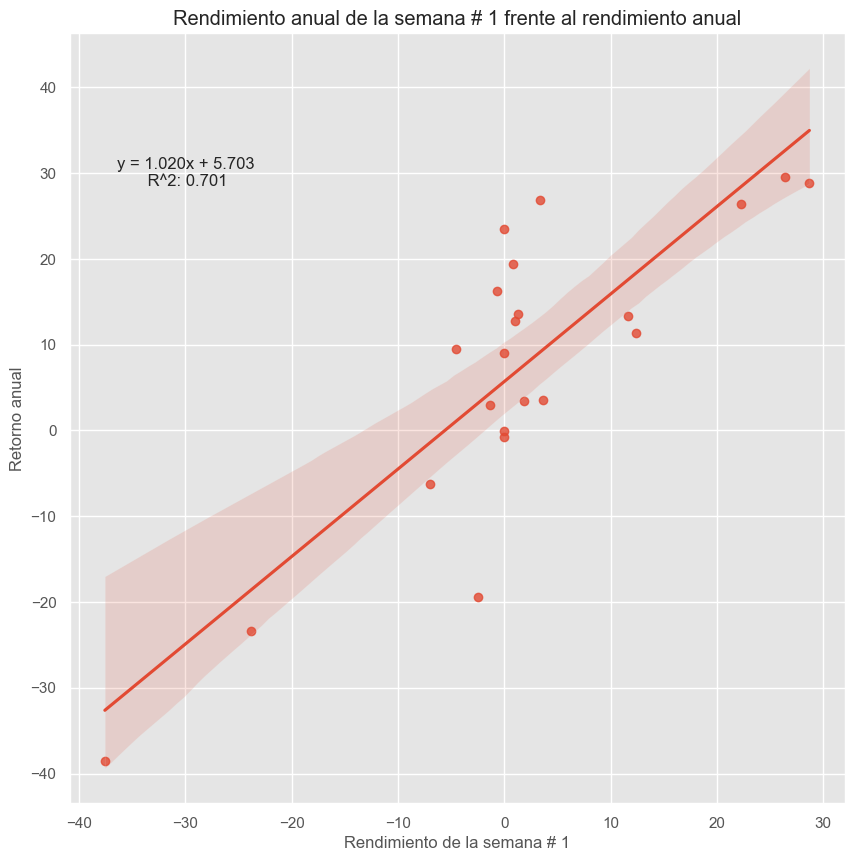

In [ ]:
#Encontrando la correlación entre el cambio de precio durante la primera semana del año y el retorno de precio anual
df = w_df[w_df["Wk"] == 1].drop(['Wk_open','Wk_end','Wk_avg','Wk_median'],axis = 1)
df2 = yr_df[["Year","P_yr"]]

df3 = pd.merge(df,df2, on = "Year").drop(index=0) # dropped 1950 since P_yr = NaN

pearson_coef, p_value = stats.pearsonr(df3['P_wk'], df3['P_yr'])
print("El coeficiente de correlación de Pearson es", pearson_coef, " con un valor P de P =", p_value,
      "\nIndica que la relación lineal es positiva y moderadamente fuerte.",
      "Además, tenga en cuenta que estas variables no son verdaderamente independientes ya que los datos semanales también forman parte del cálculo de datos anuales.\n")

lm = LinearRegression() 
lm.fit(df3[['P_wk']], df3['P_yr']) 
r2 = lm.score(df3[['P_wk']], df3['P_yr']) 
slope = lm.coef_[0]
intercept = lm.intercept_

#trazar figura con regresión y ecuación
plt.figure(figsize = (10,10))
plt.title("Rendimiento anual de la semana # 1 frente al rendimiento anual")
plt.text(-30, 30, "y = {0:.3f}x + {1:.3f}\n R^2: {2:.3f}".format(slope,intercept,r2), fontsize = 12, wrap = True,
                 horizontalalignment='center', verticalalignment='center')
s = sns.regplot(x="P_wk",y="P_yr", data = df3)
s.set(xlabel = "Rendimiento de la semana # 1", ylabel = "Retorno anual")

#### ¿Cuáles son las 10 principales ganancias y pérdidas mensuales del S&P 500?

In [ ]:
print("Las 10 principales ganancias mensuales son: \n")
ganancias_mensuales=m_df.sort_values(by=['P_mnth','M_nm'],ascending=False).head(11).reset_index(drop=True).shift()[1:]
ganancias_mensuales

Las 10 principales ganancias mensuales son: 



,Year,M_nm,M_open,M_end,M_avg,M_median,P_mnth
1,2020.0,April,2470.500000,2912.429932,2761.975226,2797.800049,17.888279
2,2011.0,October,1099.229980,1253.300049,1207.216187,1209.880005,14.016181
3,2009.0,March,700.820007,797.869995,757.126814,762.544983,13.848062
4,2008.0,December,816.210022,903.250000,877.561818,874.830017,10.663919
5,2020.0,November,3310.239990,3621.629883,3548.992480,3570.224976,9.406868
6,2001.0,April,1145.869995,1249.459961,1189.837000,1187.655029,9.040290
7,2015.0,October,1923.819946,2079.360107,2024.812716,2021.399963,8.084965
8,2022.0,July,3825.330078,4130.290039,3911.729492,3901.000000,7.972121
9,2019.0,January,2510.030029,2704.100098,2607.389997,2616.100098,7.731783
10,2009.0,April,811.080017,872.809998,848.151899,851.919983,7.610837


In [ ]:
print("Las 10 principales pérdidas mensuales son: \n")
pérdidas_mensuales=m_df.sort_values(by=['P_mnth','M_nm']).head(11).reset_index(drop=True).shift()[1:]
pérdidas_mensuales

Las 10 principales pérdidas mensuales son: 



,Year,M_nm,M_open,M_end,M_avg,M_median,P_mnth
1,2008.0,October,1161.060059,968.750000,968.800874,954.090027,-16.563317
2,2020.0,March,3090.229980,2584.590088,2652.393632,2605.619995,-16.362533
3,2009.0,January,931.799988,825.880005,865.575500,847.915009,-11.367245
4,2009.0,February,825.440002,735.090027,805.227369,825.440002,-10.945674
5,2018.0,December,2790.370117,2506.850098,2567.307386,2546.159912,-10.160660
6,2001.0,February,1373.469971,1239.939941,1305.751580,1315.920044,-9.722093
7,2022.0,September,3966.850098,3585.620117,3850.520496,3899.889893,-9.610395
8,2010.0,May,1202.260010,1089.410034,1125.062006,1124.475037,-9.386487
9,2022.0,April,4545.859863,4131.930176,4391.295996,4404.989990,-9.105641
10,2020.0,February,3248.919922,2954.219971,3277.314183,3337.750000,-9.070705


La mitad de las 10 principales pérdidas mensuales más grandes ocurrieron alrededor de una recesión según lo cuantificado por la [National Bureau of Economic Research (NBER)](https://www.nber.org/research/business-cycle-dating). Mientras que 6 de las 10 principales ganancias mensuales ocurrieron en años posteriores a una pérdida mensual significativa (10 principales).

#### ¿Cuáles son las 10 principales ganancias y pérdidas anuales del S&P 500?

In [ ]:
print("Las 10 principales ganancias anuales son: \n")
ganancias_anuales=yr_df.sort_values(by=['P_yr','Year'],ascending=False).head(11).reset_index(drop=True).shift()[1:].drop(['Avg_close','Max_date','Min_date'], axis = 1)
ganancias_anuales

Las 10 principales ganancias anuales son: 



,Year,Max_close,Min_close,Med_close,Yr_open,Yr_end,P_yr
1,2013.0,1848.359985,1457.150024,1650.404968,1462.420044,1848.359985,29.601250
2,2019.0,3240.020020,2447.889893,2919.024902,2510.030029,3230.780029,28.878070
3,2021.0,4793.060059,3700.649902,4304.000000,3700.649902,4766.180176,26.892739
4,2003.0,1111.920044,800.729980,986.029999,909.030029,1111.920044,26.380400
5,2009.0,1127.780029,676.530029,939.145020,931.799988,1115.099976,23.454190
6,2017.0,2690.159912,2257.830078,2436.100098,2257.830078,2673.610107,19.419966
7,2020.0,3756.070068,2237.399902,3276.020020,3257.850098,3756.070068,16.258923
8,2006.0,1427.089966,1223.689941,1296.060059,1268.800049,1418.300049,13.619432
9,2012.0,1465.770020,1277.060059,1383.669983,1277.060059,1426.189941,13.405691
10,2010.0,1259.780029,1022.580017,1136.984985,1132.989990,1257.640015,12.782714


In [ ]:
print("Las 10 principales pérdidas anuales son: \n")
pérdidas_anuales=yr_df.sort_values(by=['P_yr','Year']).head(11).reset_index(drop=True).shift()[1:].drop(['Avg_close','Max_date','Min_date'], axis = 1)
pérdidas_anuales

Las 10 principales pérdidas anuales son: 



,Year,Max_close,Min_close,Med_close,Yr_open,Yr_end,P_yr
1,2008.0,1447.160034,752.440002,1289.189941,1447.160034,903.250000,-38.485793
2,2002.0,1172.510010,776.760010,971.090027,1154.670044,879.820007,-23.365964
3,2022.0,4796.560059,3577.030029,4027.260010,4796.560059,3839.500000,-19.442827
4,2001.0,1373.729980,965.799988,1190.539978,1283.270020,1148.079956,-13.042693
5,2018.0,2930.750000,2351.100098,2743.149902,2695.810059,2506.850098,-6.237260
6,2015.0,2130.820068,1867.609985,2079.395020,2058.199951,2043.939941,-0.726600
7,2011.0,1363.609985,1099.229980,1281.895020,1271.869995,1257.599976,-0.003184
8,2005.0,1272.739990,1137.500000,1204.100037,1202.079956,1248.290039,3.001023
9,2023.0,4179.759766,3808.100098,3990.969971,3824.139893,3970.989990,3.424664
10,2007.0,1565.150024,1374.119995,1476.270020,1416.599976,1468.359985,3.529573


In [ ]:
print(f"El rendimiento anual promedio para el es {yr_df['P_yr'].mean():.3%}")

El rendimiento anual promedio para el es 648.971%


#### ¿Cuáles son las 10 principales ganancias y pérdidas comerciales después de hora para el S&P 500?

In [ ]:
#Tabla de datos ordenada por año mayor o igual a 1991
print("Las 10 principales ganancias de la hora de negociación extendida son: \n")
ganancias_hora_extendida=data[data['Year'] >=1991].sort_values(by=['PEx_trd','Year'],ascending=False).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Volume','M_num','M_nm','D_num','Year','Wk','Ex_trd'], axis = 1)
ganancias_hora_extendida

Las 10 principales ganancias de la hora de negociación extendida son: 



,Date,Open,High,Low,Close,D_nm,P_intra,P_day,P_Vol,PEx_trd
1,2020-03-24 00:00:00-04:00,2344.439941,2449.709961,2344.439941,2447.330078,Tuesday,4.490199,4.388687,2.047797,4.784126
2,2020-03-13 00:00:00-04:00,2569.989990,2711.330078,2492.370117,2711.020020,Friday,8.785210,5.487571,-6.233780,3.601897
3,2020-04-06 00:00:00-04:00,2578.280029,2676.850098,2574.570068,2663.679932,Monday,3.972703,3.312282,5.033156,3.601556
4,2022-11-10 00:00:00-05:00,3859.889893,3958.330078,3859.889893,3956.370117,Thursday,2.550337,2.499559,24.461734,2.969661
5,2020-04-07 00:00:00-04:00,2738.649902,2756.889893,2657.669922,2659.409912,Tuesday,3.733344,-2.893396,10.096598,2.814526
6,2020-03-10 00:00:00-04:00,2813.479980,2882.590088,2734.000000,2882.229980,Tuesday,5.434897,2.443593,-9.468340,2.436499
7,2020-06-12 00:00:00-04:00,3071.040039,3088.419922,2984.469971,3041.310059,Friday,3.483029,-0.968075,-16.938124,2.296390
8,2020-06-16 00:00:00-04:00,3131.000000,3153.449951,3076.060059,3124.739990,Tuesday,2.515877,-0.199936,1.534178,2.100376
9,2020-11-09 00:00:00-05:00,3583.040039,3645.989990,3547.479980,3550.500000,Monday,2.776901,-0.908168,76.986697,2.097204
10,2022-12-13 00:00:00-05:00,4069.379883,4100.959961,3993.030029,4019.649902,Tuesday,2.702958,-1.222053,30.102225,1.975157


In [ ]:
print("Las 10 principales pérdidas de horas de negociación extendidas son: \n")
pérdidas_hora_extendida=data[data['Year'] >=1991].sort_values(by=['PEx_trd','Year']).head(11).reset_index(drop=True).shift()[1:].drop(
    ['Volume','M_num','M_nm','D_num','Year','Wk','Ex_trd'], axis = 1)
pérdidas_hora_extendida

Las 10 principales pérdidas de horas de negociación extendidas son: 



,Date,Open,High,Low,Close,D_nm,P_intra,P_day,P_Vol,PEx_trd
1,2020-03-16 00:00:00-04:00,2508.590088,2562.979980,2380.939941,2386.129883,Monday,7.645722,-4.881635,-5.947895,-7.466929
2,2020-03-12 00:00:00-04:00,2630.860107,2660.949951,2478.860107,2480.639893,Thursday,7.345709,-5.709928,19.103375,-4.031538
3,2020-03-18 00:00:00-04:00,2436.500000,2453.570068,2280.520020,2398.100098,Wednesday,7.588184,-1.576027,5.125892,-3.664807
4,2020-03-09 00:00:00-04:00,2863.889893,2863.889893,2734.429932,2746.560059,Monday,4.734441,-4.096870,28.771639,-3.649620
5,2020-04-01 00:00:00-04:00,2498.080078,2522.750000,2447.489990,2470.500000,Wednesday,3.074987,-1.104051,-9.309465,-3.347146
6,2020-03-27 00:00:00-04:00,2555.870117,2615.909912,2520.020020,2541.469971,Friday,3.805124,-0.563415,-20.153496,-2.821216
7,2020-02-24 00:00:00-05:00,3257.610107,3259.810059,3214.649902,3225.889893,Monday,1.404823,-0.973727,24.109313,-2.401015
8,2020-03-06 00:00:00-05:00,2954.199951,2985.929932,2901.540039,2972.370117,Friday,2.908452,0.615062,17.492369,-2.306262
9,2020-06-11 00:00:00-04:00,3123.530029,3123.530029,2999.489990,3002.100098,Thursday,4.135371,-3.887586,6.644319,-2.087992
10,2020-02-28 00:00:00-05:00,2916.899902,2959.719971,2855.840088,2954.219971,Friday,3.637454,1.279443,21.301087,-2.076707


Todas las ganancias y pérdidas de los 10 principales después de la hora ocurrieron durante 2020, muy probablemente debido a la pandemia de COVID-19 y al apoyo fiscal y monetario resultante tanto en los Estados Unidos como a bordo. Según la correlación de Pearson que se muestra a continuación, las operaciones posteriores a la hora no parecen tener una correlación significativa con el movimiento de precios del día siguiente. Las ganancias/pérdidas después de la hora no tienen un impacto significativo en el movimiento de precios del siguiente día de negociación.

El coeficiente de correlación de Pearson es 0.254 con un valor P de P = 3.6537974588891216e-61 
Indica una pequeña relación lineal entre el comercio después de la hora y los cambios de precios diarios.


[Text(0.5, 0, 'Trading después de la hora'),
 Text(0, 0.5, 'Rendimiento al día siguiente')]

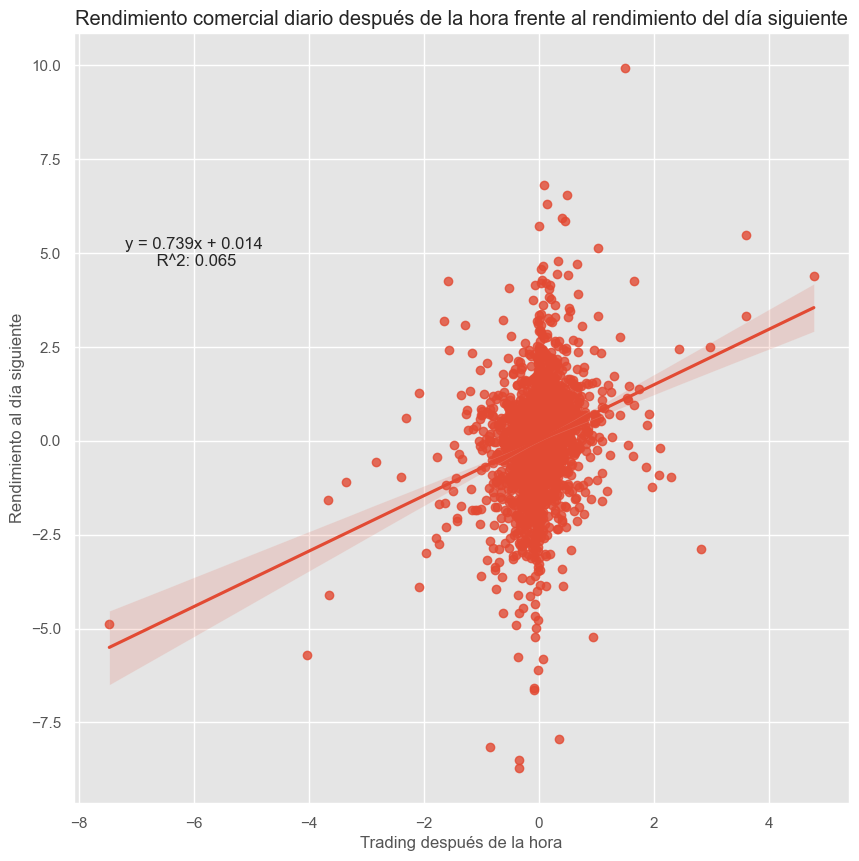

In [ ]:
df4 = data[data['Year'] >=1991].dropna() 

pearson_coef, p_value = stats.pearsonr(df4['PEx_trd'], df4['P_day'])
print("El coeficiente de correlación de Pearson es", round(pearson_coef,3), "con un valor P de P =", p_value,
      "\nIndica una pequeña relación lineal entre el comercio después de la hora y los cambios de precios diarios.")
lm = LinearRegression() 
lm.fit(df4[['PEx_trd']], df4['P_day']) 
r2 = lm.score(df4[['PEx_trd']], df4['P_day']) 
slope = lm.coef_[0]
intercept = lm.intercept_

#trazar figura con regresión y ecuación
plt.figure(figsize = (10,10))
plt.title("Rendimiento comercial diario después de la hora frente al rendimiento del día siguiente")
plt.text(-6, 5, "y = {0:.3f}x + {1:.3f}\n R^2: {2:.3f}".format(slope,intercept,r2), fontsize = 12, wrap = True,
                 horizontalalignment='center', verticalalignment='center')
s = sns.regplot(x="PEx_trd",y="P_day", data = df4)
s.set(xlabel = "Trading después de la hora", ylabel = "Rendimiento al día siguiente")

<a id="Sub-2"></a>
# *Visualización de datos*

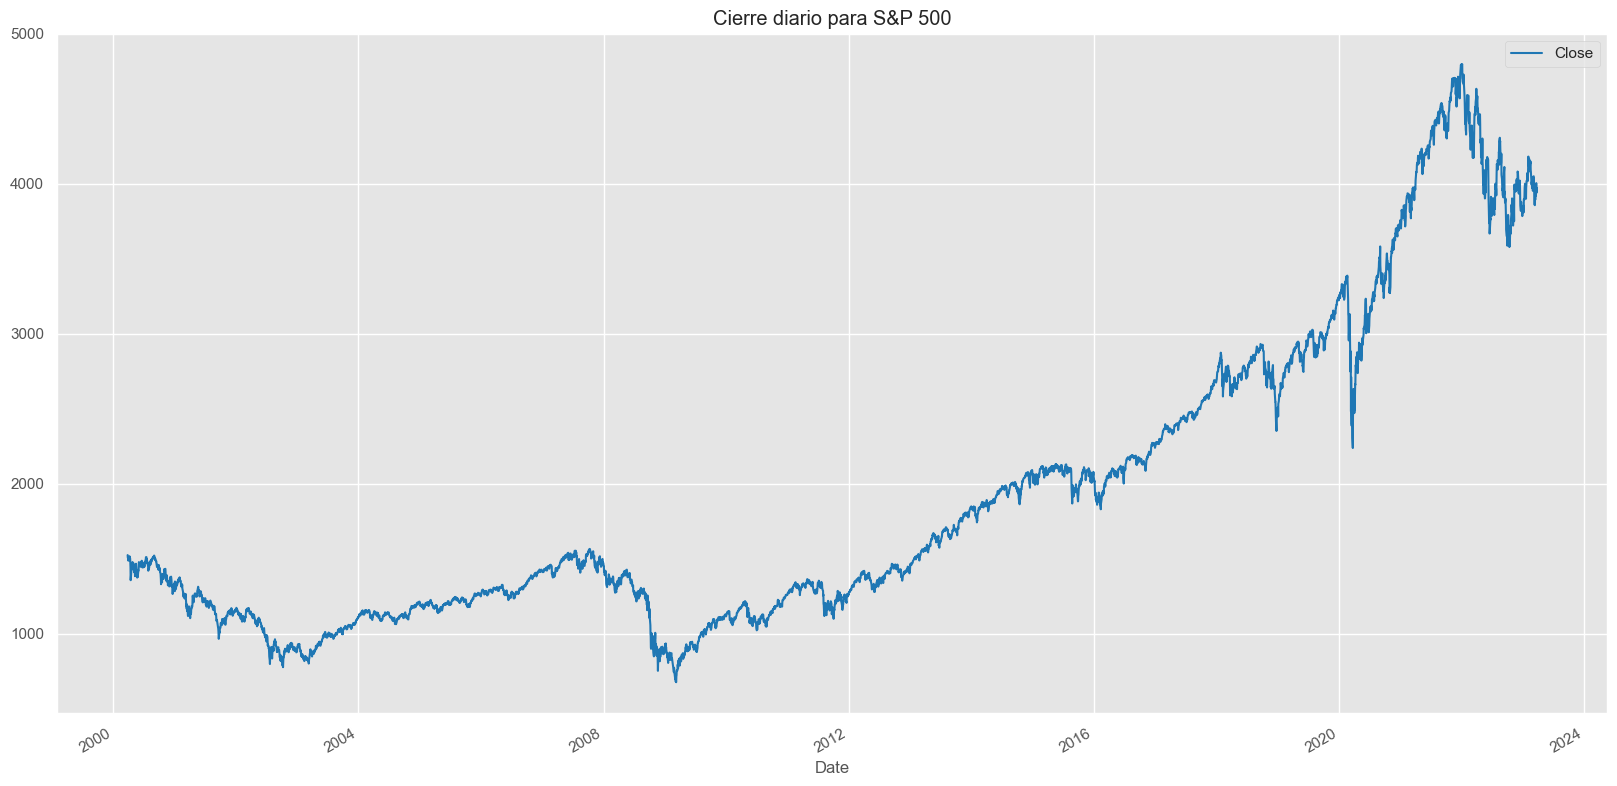

In [ ]:
data.plot(x="Date",y="Close",title = "Cierre diario para S&P 500",figsize = (20,10),colormap= 'tab10')
plt.show()

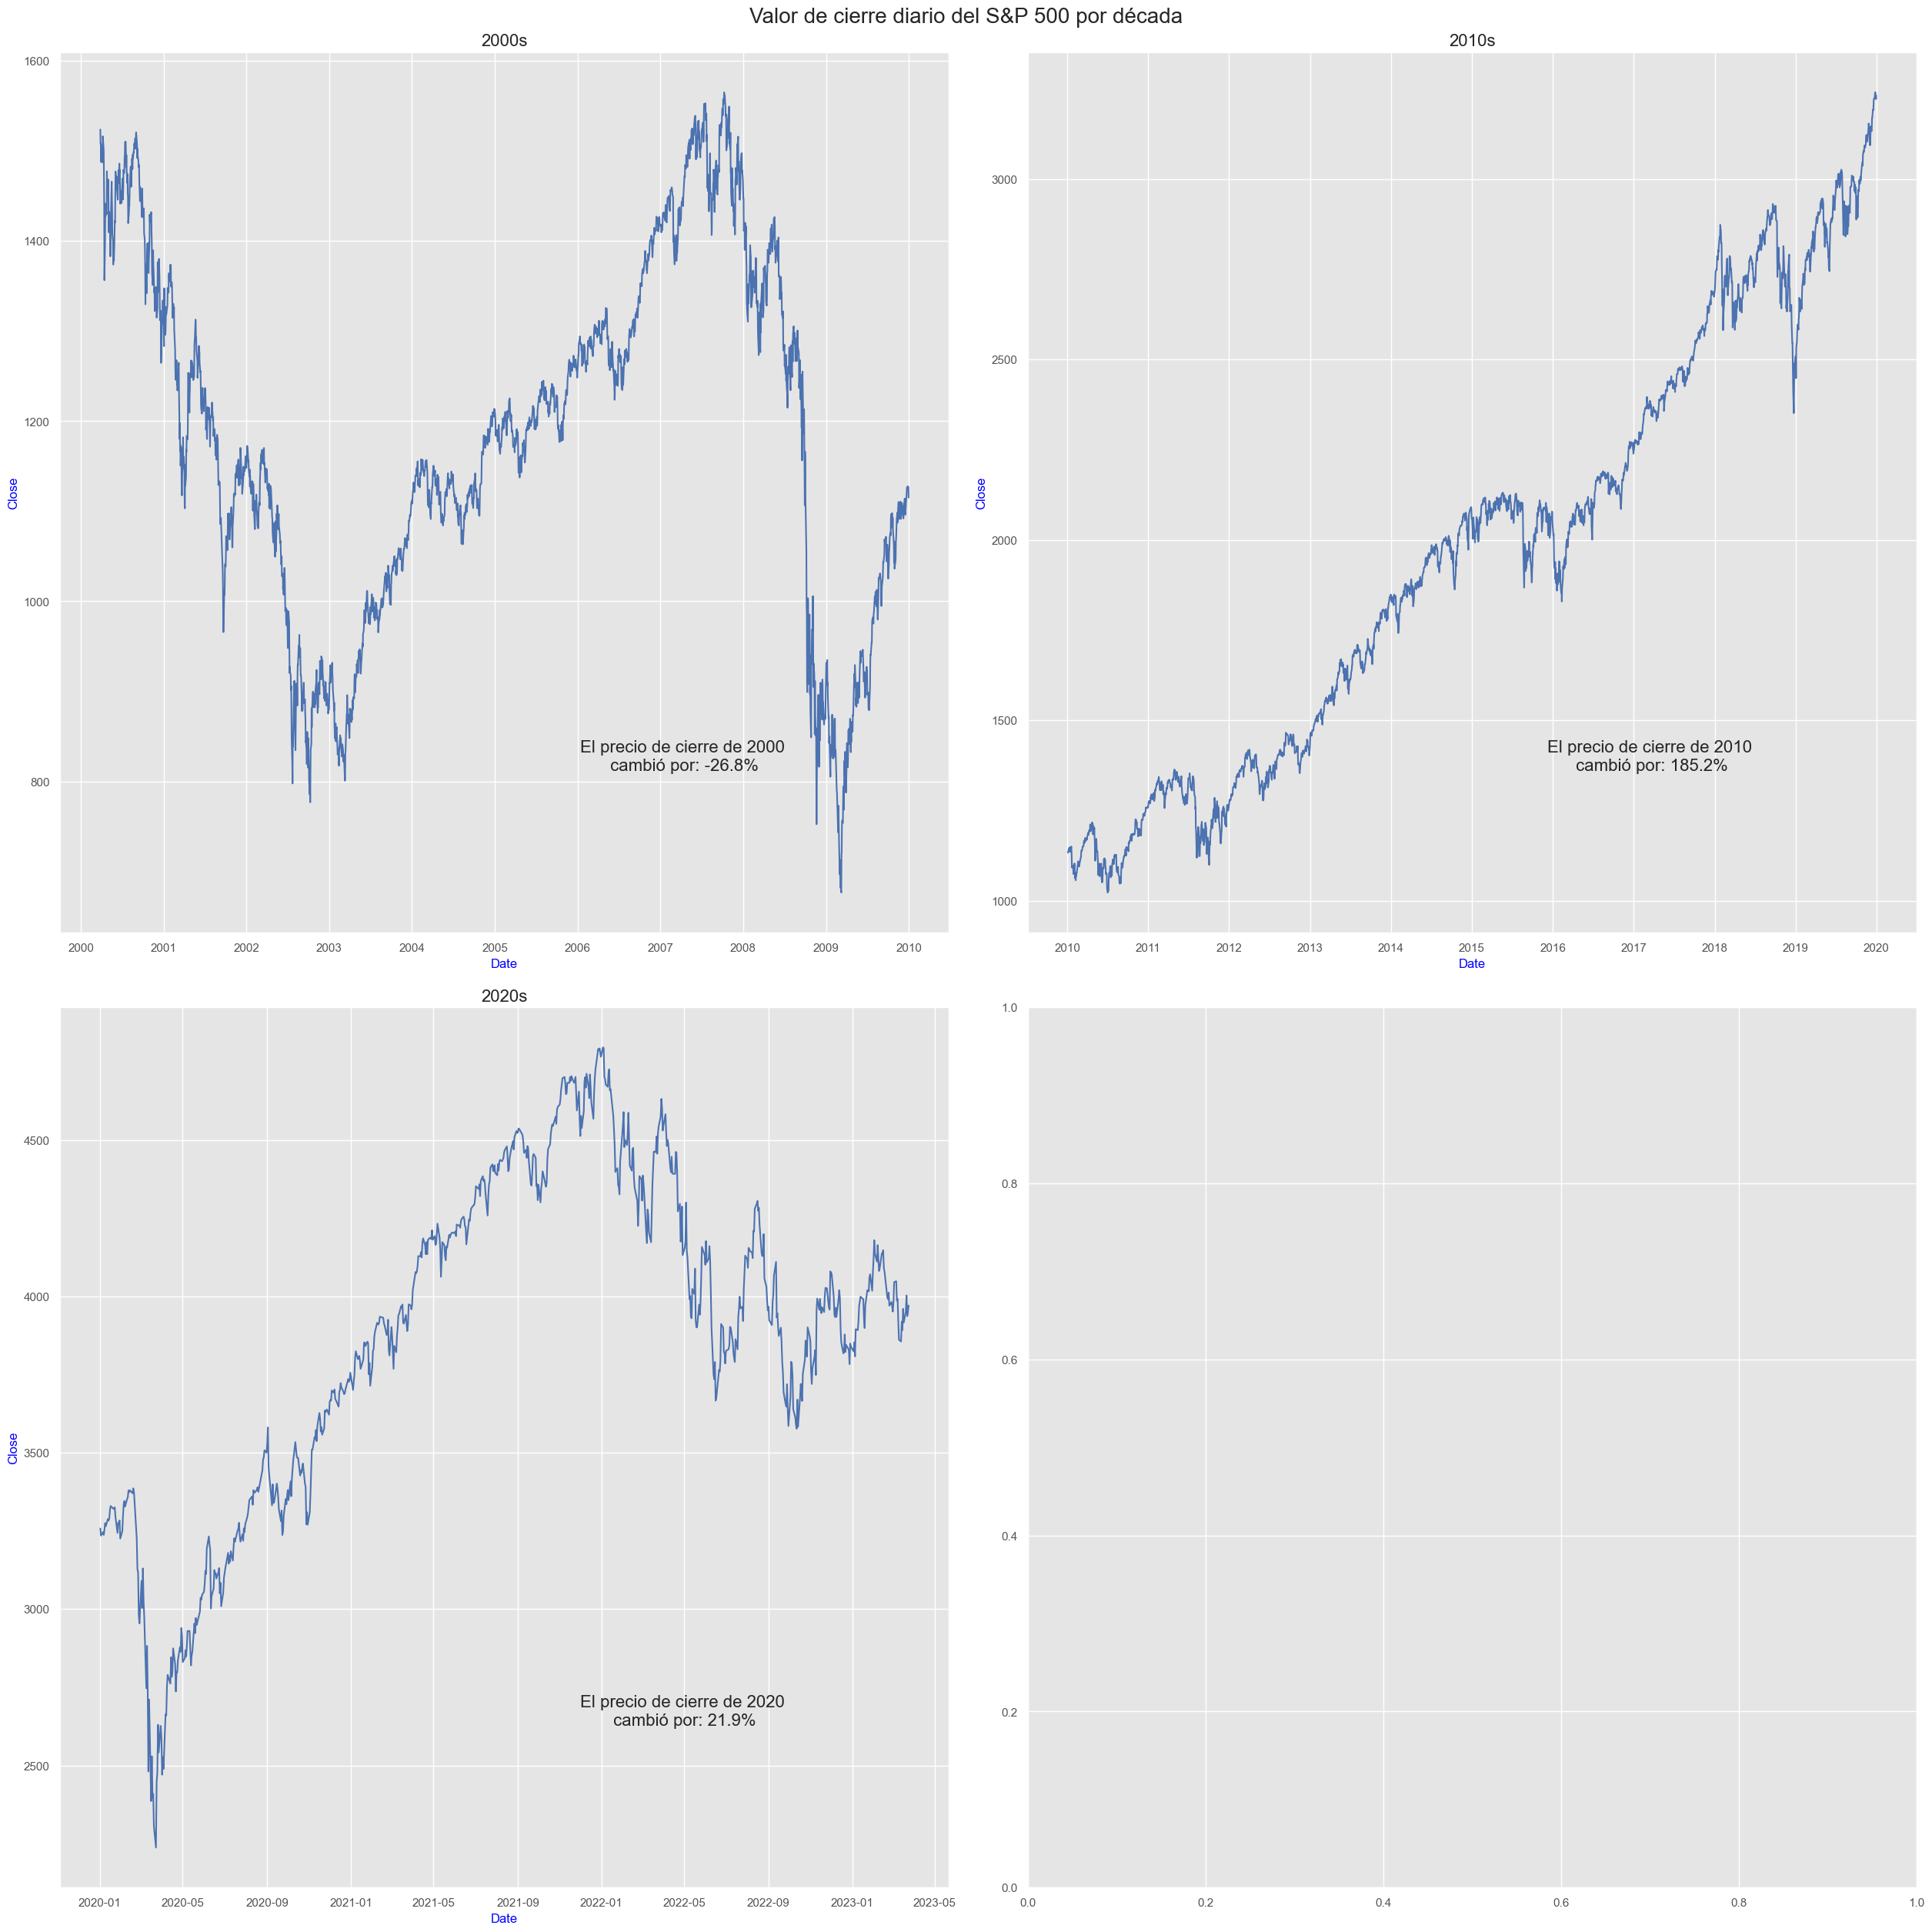

In [ ]:
## encontrar años que son divisibles por 10
decade = list(data[data['Year']%10 == 0]['Year'].unique())

#Crear figura para subplots
fig,ax = plt.subplots(nrows = int(round(len(decade)/2)), ncols =2, figsize=(25,25), constrained_layout=True)
plt.suptitle("Valor de cierre diario del S&P 500 por década",fontsize = 20)
#Recorre cada fila y columna para crear una gráfica para cada década
i = 0
for row in ax:
    for col in row:
        start = decade[i]
        if i == (len(decade) - 1): #If at last 10s then just pull last 'year' from dataframe
            end = data['Year'].tail(1).loc[0:'Year'].iloc[0]+1
        else:
            end = decade[i+1]
            
        #Poner title al plot
        col.set_title(str(start)+'s', fontsize = 16)
        
        #Extraer datos para cada década
        x = data[(data['Year'] >= start) & (data['Year'] < end )]['Date'].dt.date
        y = data[(data['Year'] >= start) & (data['Year'] < end )]['Close']  
    
        col.plot(x,y,'-b')
        col.set_xlabel("Date", color = 'blue')
        col.set_ylabel("Close", color = 'blue')
        
        gain = p_chg(y.iloc[0],y.iloc[-1]) #Calcule la ganancia de la década desde el primer día de negociación hasta el último día de negociación
        col.text(0.7, 0.2, "El precio de cierre de {0}\n cambió por: {1:.1f}%".format(start,gain), fontsize = 16, wrap = True,
                 horizontalalignment='center', verticalalignment='center', transform=col.transAxes)
        i += 1
        if i == len(decade): #Una vez que el índice es igual a la longitud de la lista de décadas, deja de iterar a través del ciclo
            break

plt.show()

El siguiente gráfico muestra los rendimientos anuales del S&P 500. En general, hay muchos más años positivos que años negativos. Y es raro tener una disminución del 20% o más.

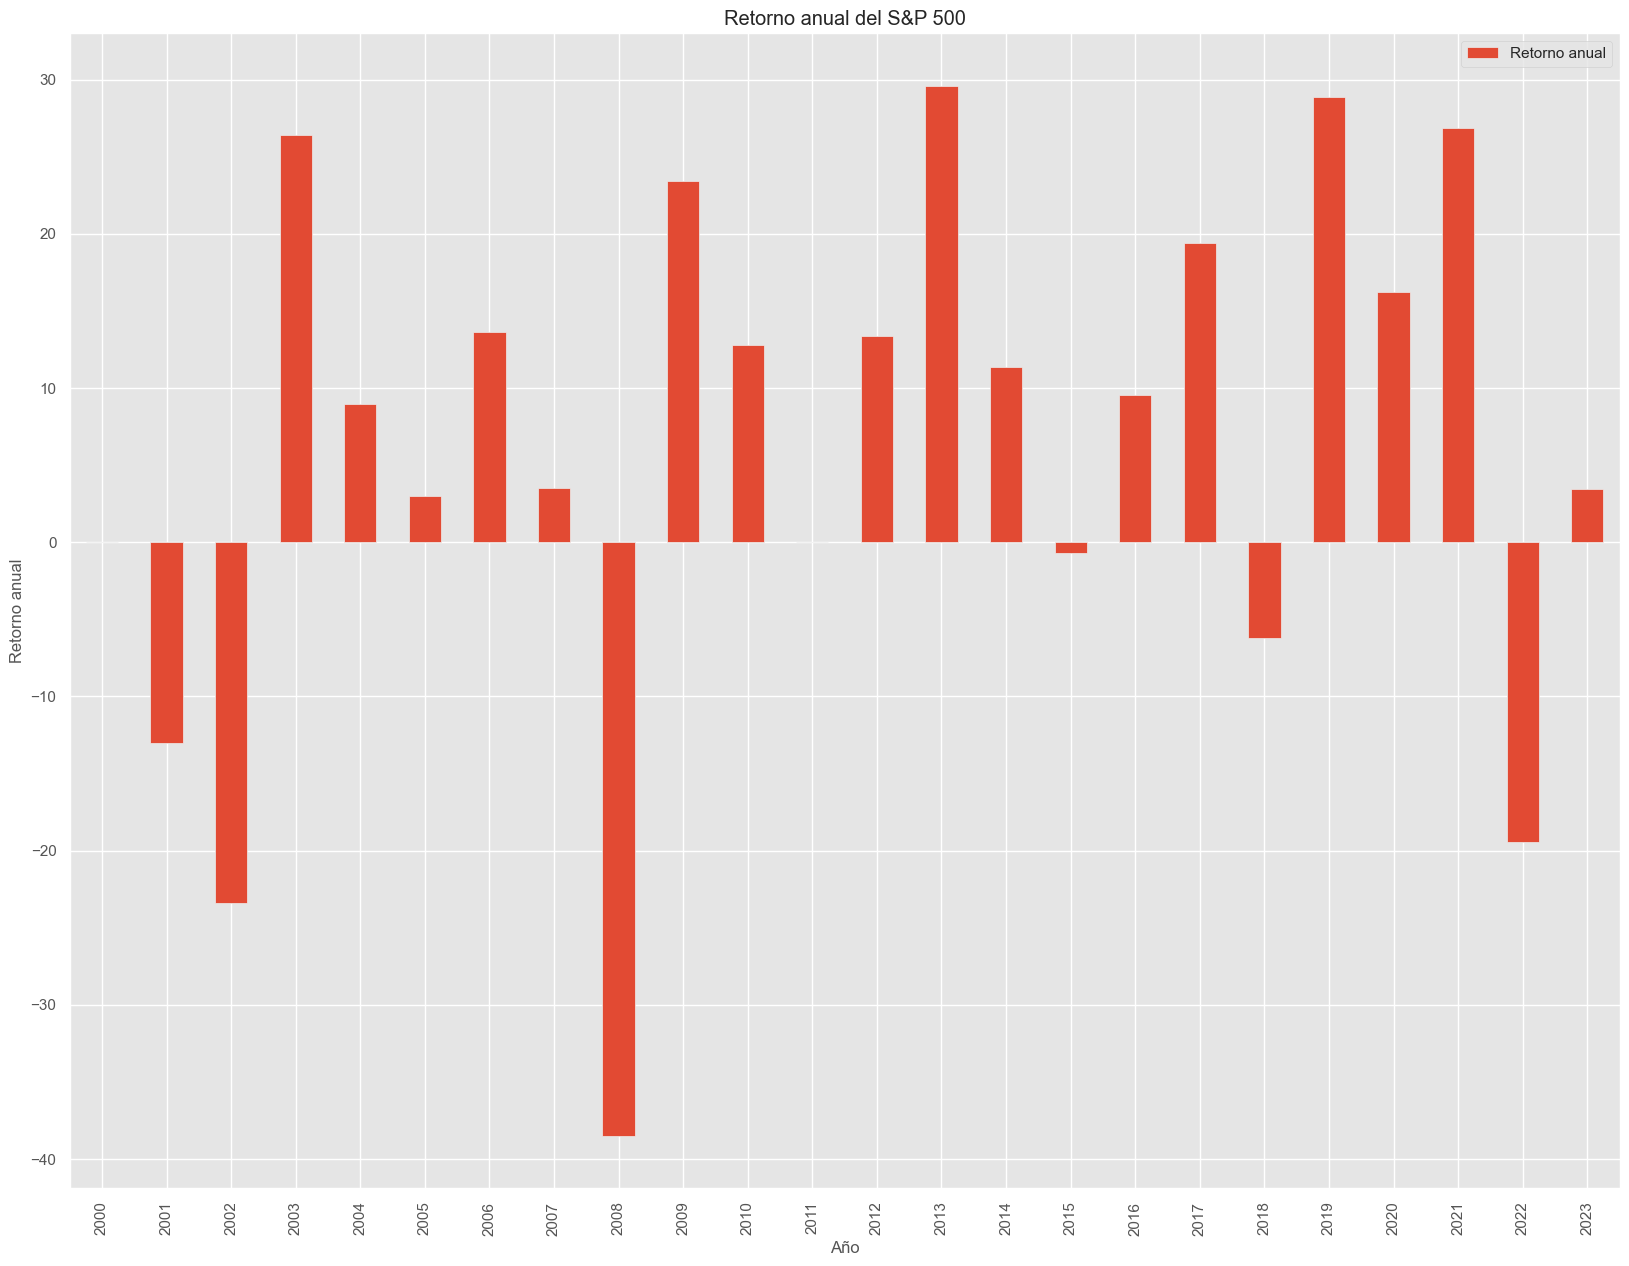

In [ ]:
yr_df.plot.bar(x='Year',y='P_yr',color='C0', label='Retorno anual', figsize = (20,15))
plt.title('Retorno anual del S&P 500')
plt.ylabel("Retorno anual")
plt.xlabel("Año")
plt.show()

El siguiente histograma muestra la frecuencia de los rendimientos anuales del S&P 500.

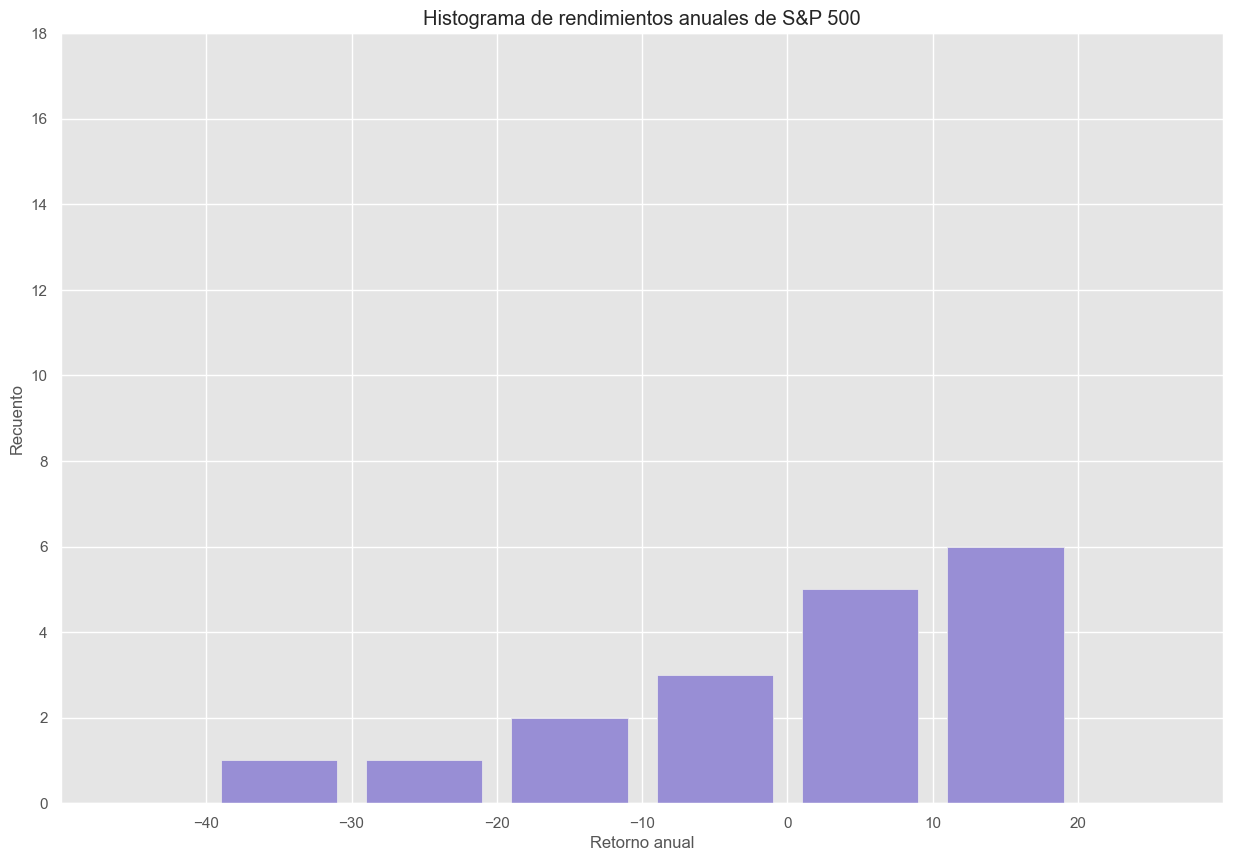

In [ ]:
#obtención de límites altos y bajos para el gráfico
high = int(round(yr_df['P_yr'].max()/10,0))*10
low = int(round(yr_df['P_yr'].min()/10,0))*10

#creación de contenedores y configuración del ancho del contenedor
count, bin_edges = np.histogram(yr_df.loc[1:,'P_yr'],bins=(range(low,high,10)))
x_min = bin_edges[0] - 10
x_max = bin_edges[-1] + 10

#Encuentre el recuento máximo de un redondeo al número par más cercano
if (count.max()%2 == 0):
    ymax = 20
else:
    ymax = count.max() +2

#Trazar histograma de rendimientos anuales
yr_df.loc[1:,'P_yr'].plot.hist(bins=(range(low,high,10)), color='C9', figsize = (15,10), xticks = bin_edges, 
                               xlim = (x_min,x_max), yticks =range(0,ymax,2), rwidth = 0.8)
plt.xlabel("Retorno anual")
plt.ylabel("Recuento")
plt.title("Histograma de rendimientos anuales de S&P 500")
plt.show()

In [ ]:
print("De {0} años de datos, solo ha habido {1} años en los que el rendimiento anual ha sido inferior al -20%. Pero ha habido {2} años (o {4:.2%} ) con \
una rentabilidad anual superior al 0% y {3} (o {5:.2%}) años con una rentabilidad anual superior al 6 % (rendimiento de tesorería a 30 años en 2000)."
      .format(yr_df['Year'].count(),yr_df[yr_df['P_yr'] < -20].value_counts().count(),
              yr_df[yr_df['P_yr'] > 0].value_counts().count(),yr_df[yr_df['P_yr'] > 6].value_counts().count(),
             yr_df[yr_df['P_yr'] > 0].value_counts().count()/yr_df['Year'].count(),yr_df[yr_df['P_yr'] > 6].value_counts().count()/yr_df['Year'].count()))

De 24 años de datos, solo ha habido 2 años en los que el rendimiento anual ha sido inferior al -20%. Pero ha habido 16 años (o 66.67% ) con una rentabilidad anual superior al 0% y 13 (o 54.17%) años con una rentabilidad anual superior al 6 % (rendimiento de tesorería a 30 años en 2000).


El siguiente gráfico muestra el volumen de negociación diario.

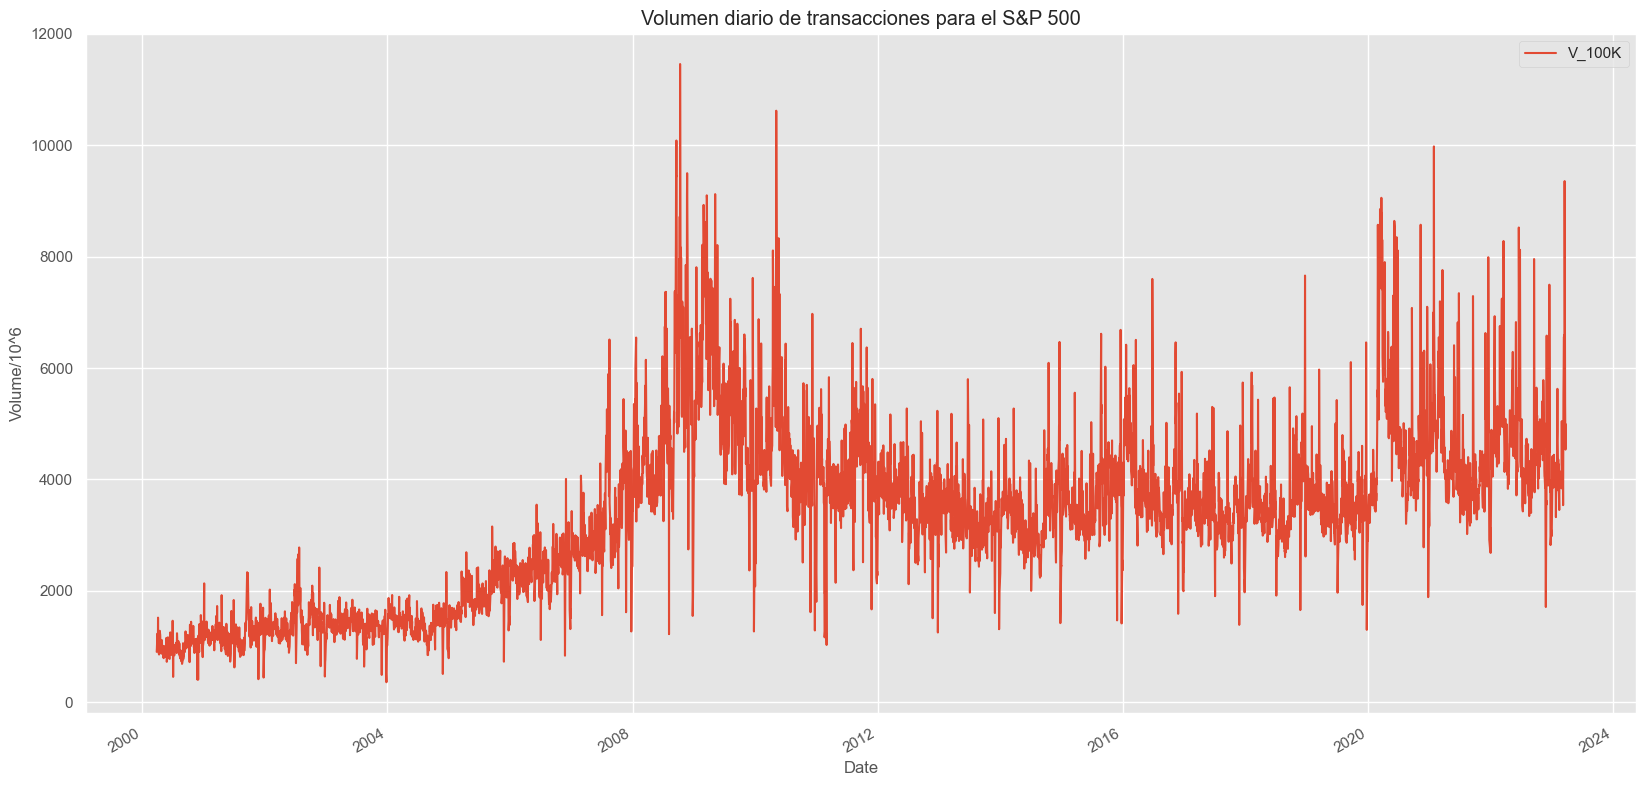

In [ ]:
yr_vol = data[["Date",'Volume']]
yr_vol = yr_vol.assign(V_100K = round(yr_vol['Volume']/(10**6),3))
yr_vol.drop(columns='Volume')

yr_vol.plot(x="Date",y="V_100K",title = "Volumen diario de transacciones para el S&P 500", figsize = (20,10))
plt.ylabel("Volume/10^6")
plt.xlabel("Date")

plt.show()

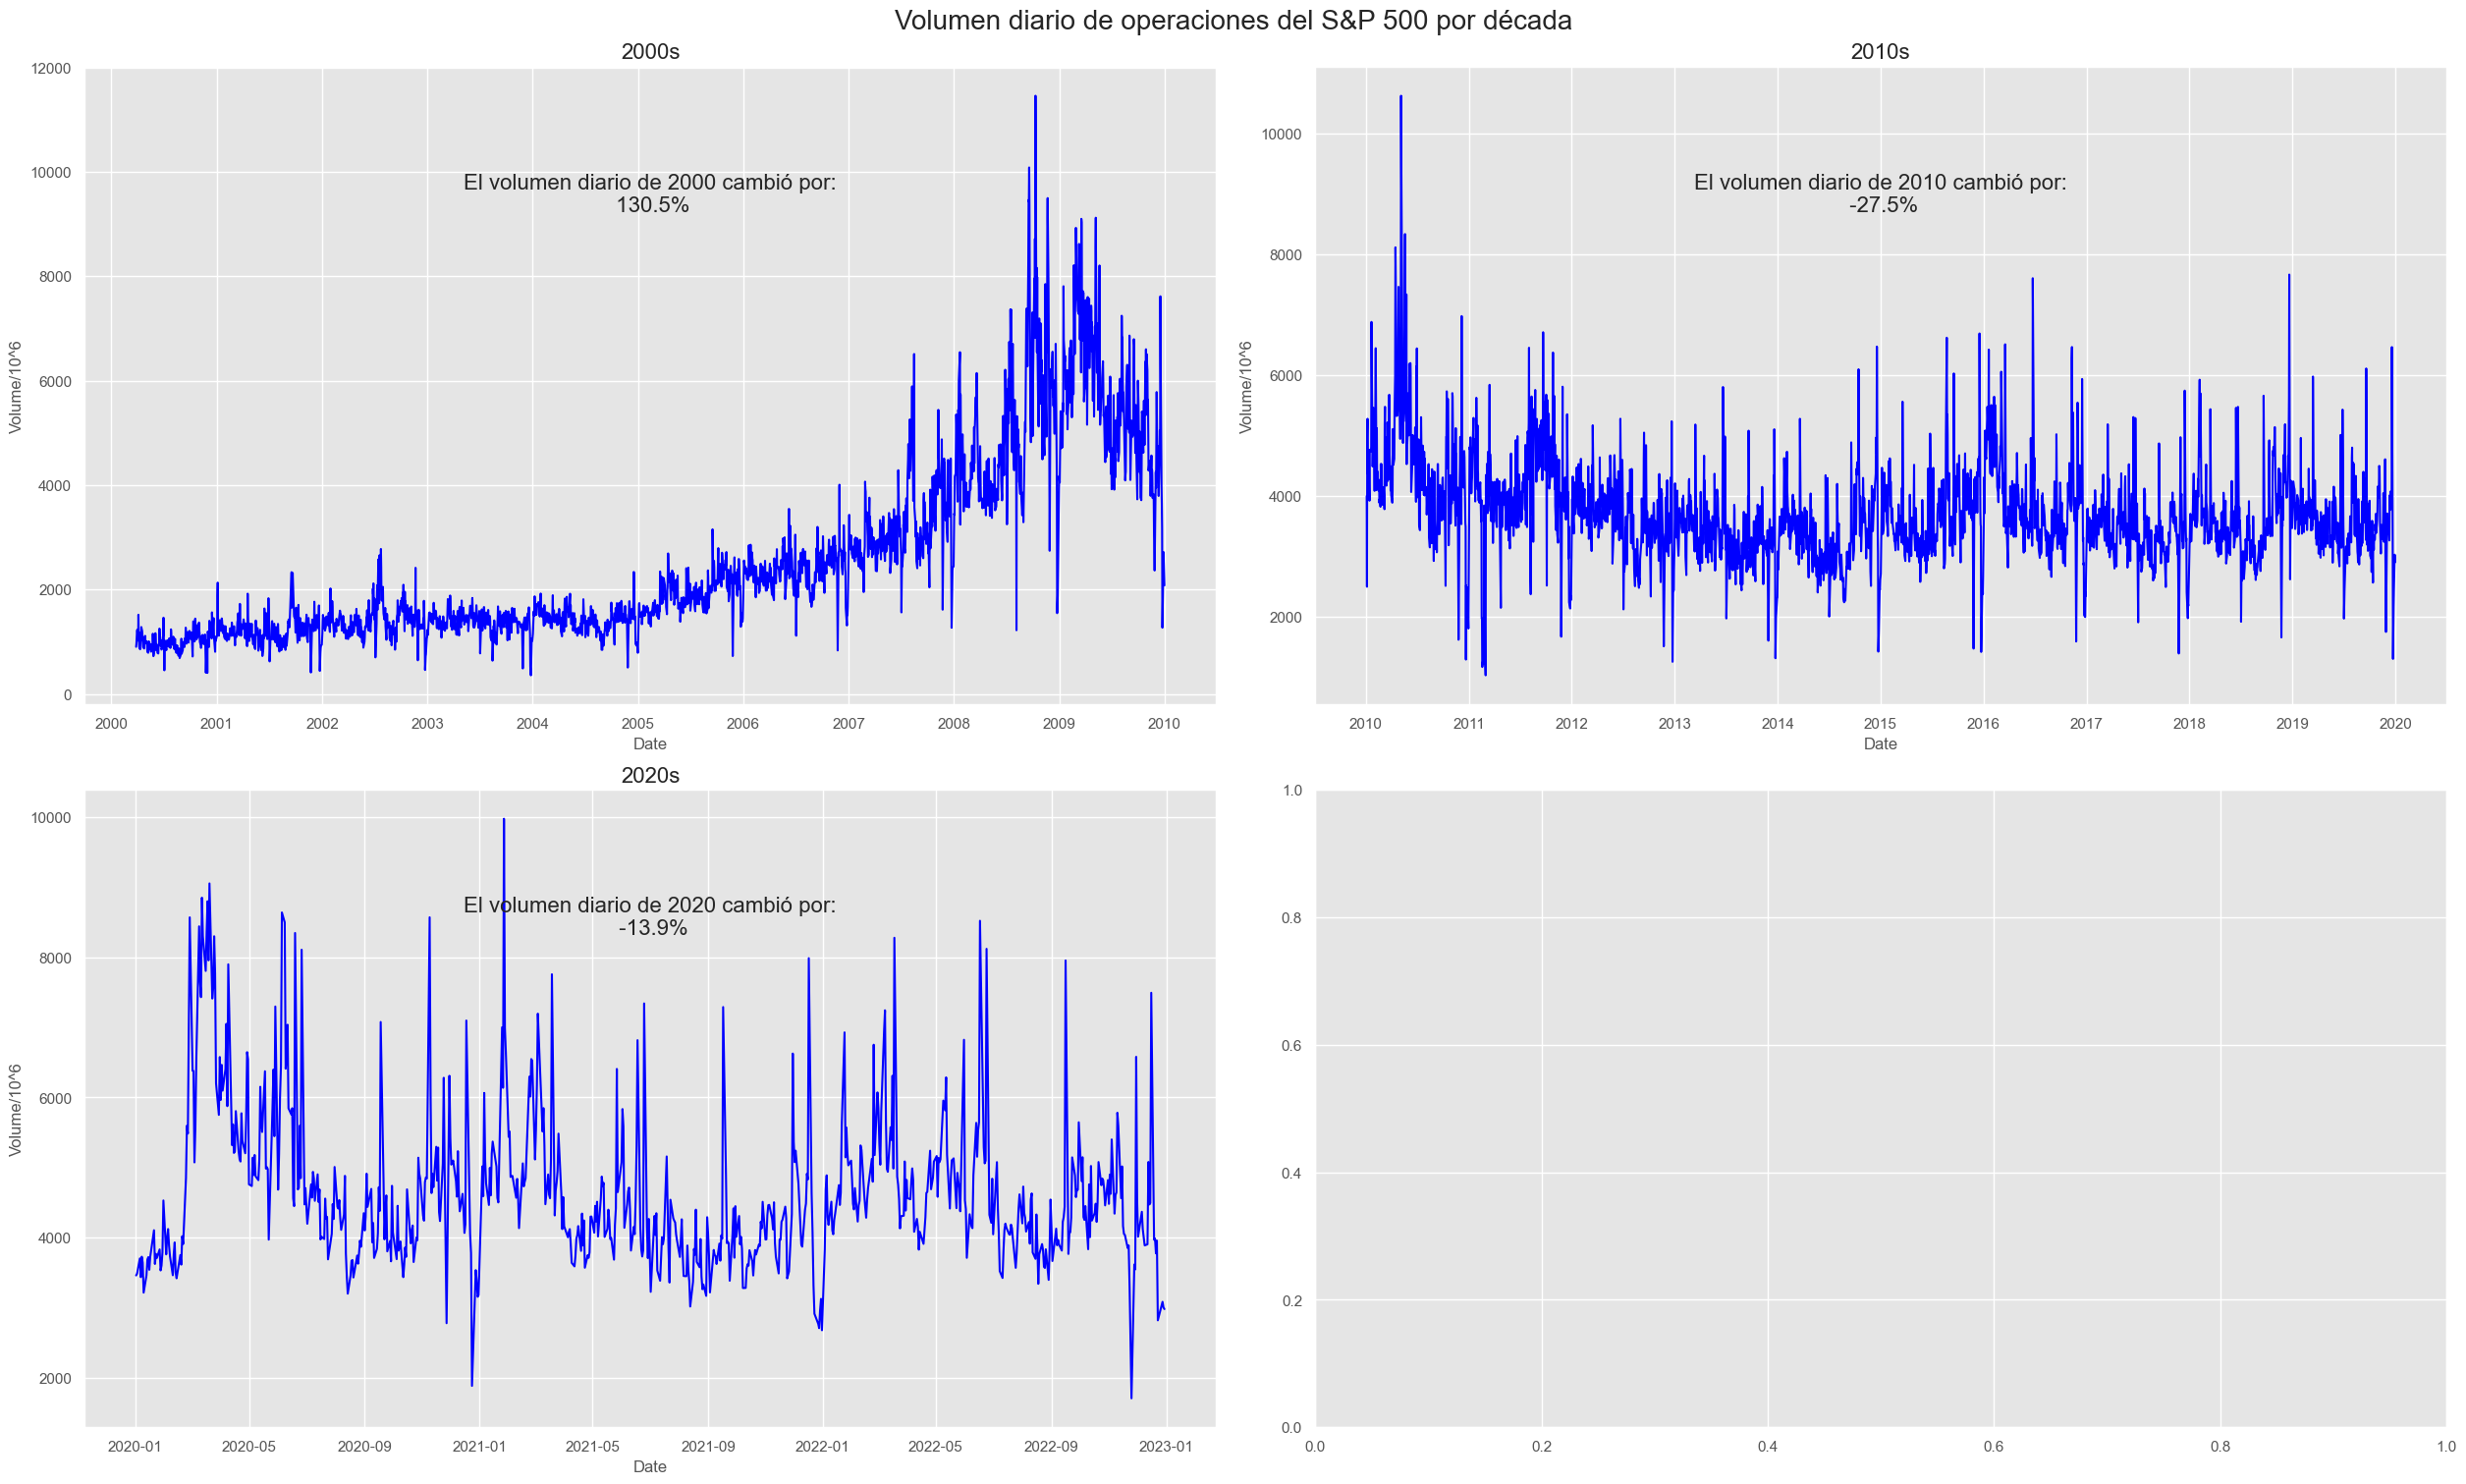

In [ ]:
## encontrar años que son divisibles por 10
decade = list(data[data['Year']%10 == 0]['Year'].unique())

fig,ax = plt.subplots(nrows = int(round(len(decade)/2)), ncols =2, figsize=(25,15), constrained_layout=True)
plt.suptitle("Volumen diario de operaciones del S&P 500 por década",fontsize = 20)

i = 0
for row in ax:
    for col in row:
        start = decade[i]
        if i == (len(decade) - 1):
            end = data['Year'].tail(1).loc[0:'Year'].iloc[0]
        else:
            end = decade[i+1]
        x = data[(data['Year'] >= start) & (data['Year'] < end )]['Date']
        y = data[(data['Year'] >= start) & (data['Year'] < end )]['Volume']/(10**6)   
        col.plot(x,y, color = 'blue')
        col.set_title(str(start)+'s', fontsize = 16)
        col.set_xlabel("Date")
        col.set_ylabel("Volume/10^6")
        gain = p_chg(y.iloc[0],y.iloc[-1])
        col.text(0.5, 0.8, "El volumen diario de {0} cambió por:\n {1:.1f}%".format(start,gain), fontsize = 16, wrap = True,
                 horizontalalignment='center', verticalalignment='center', transform=col.transAxes)
        i += 1
        if i == len(decade):
            break

plt.show()

El siguiente gráfico de cuadro muestra la volatilidad mensual del S&P 500. ¿Hay algunos meses que históricamente muestran más volatilidad que otros? Según el gráfico a continuación, octubre tiene los valores atípicos más altos y más bajos. Esto se examinó previamente en la sección de Análisis de datos como asociado con el GFC de 2008 y el Lunes Negro de 1987.

Text(-150, 30, 'Lunes negro \n Caída del 20,47 %')

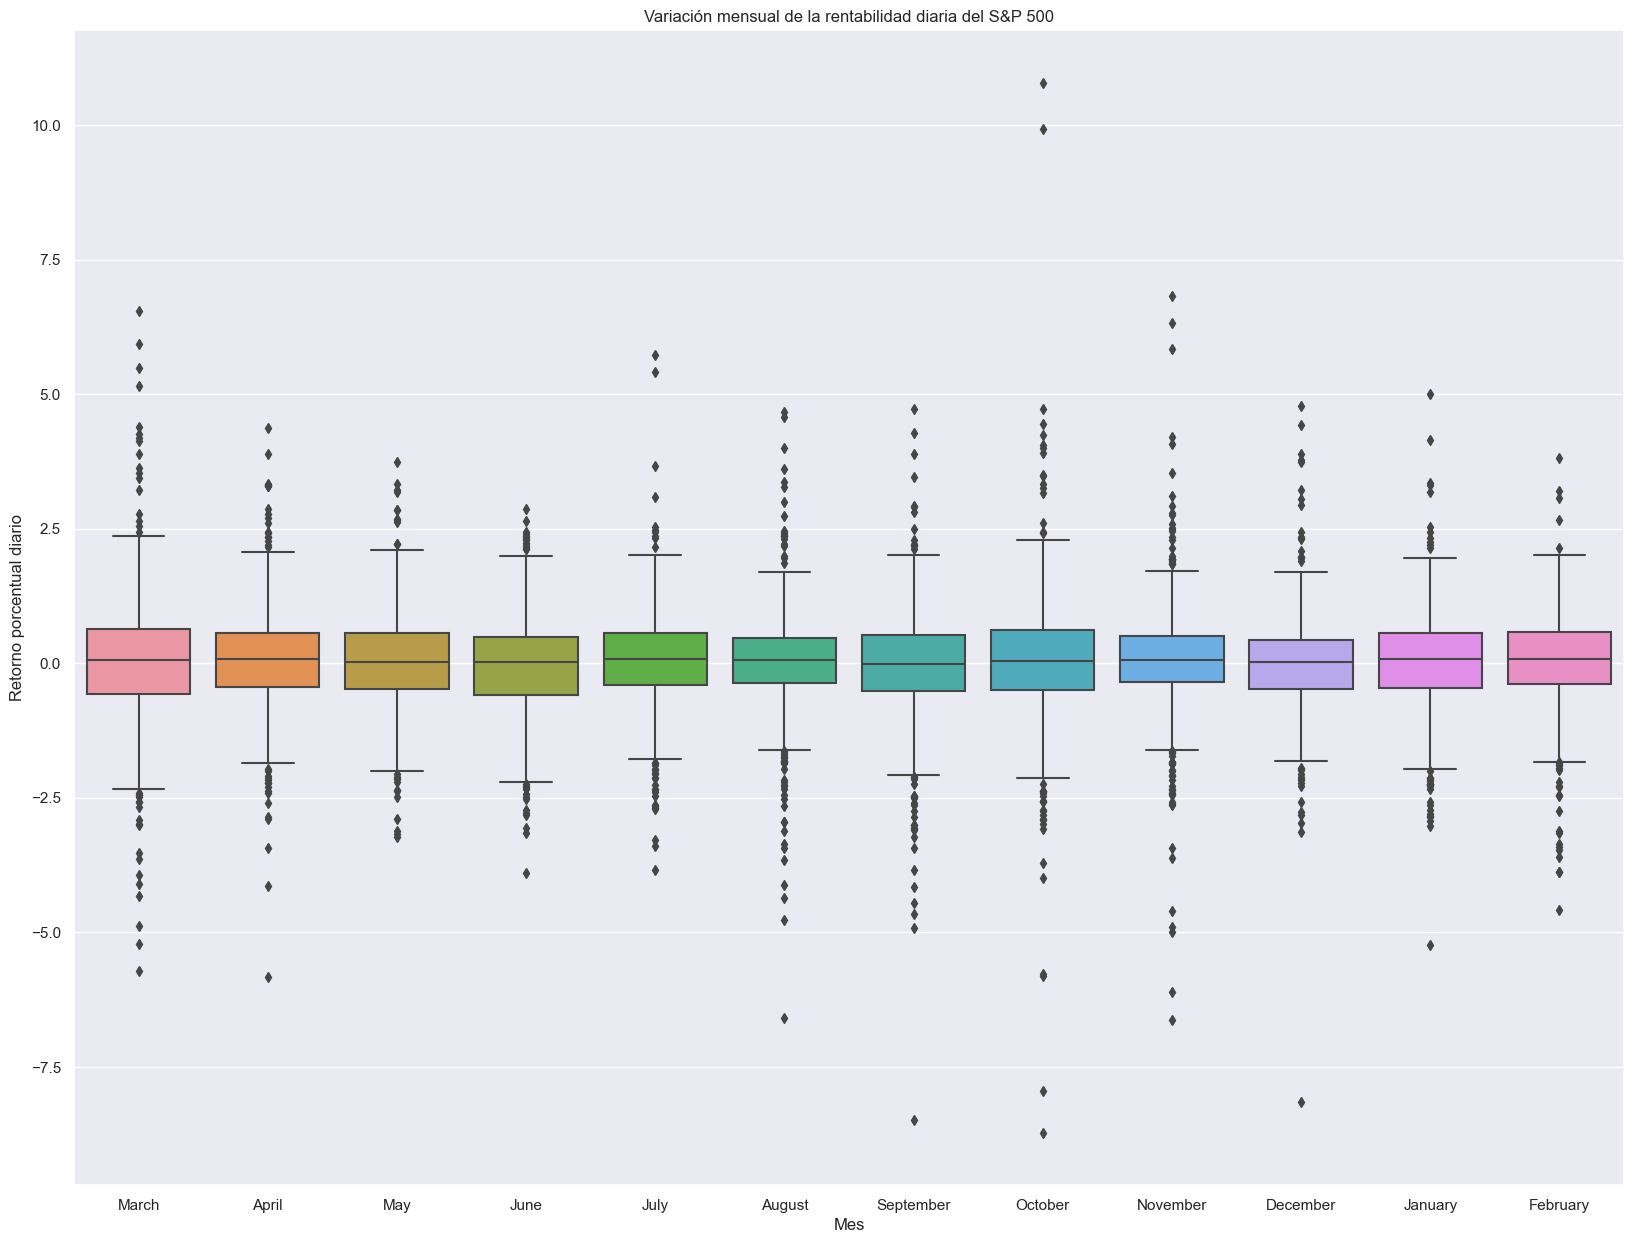

In [ ]:
#Muestra box plot para cada mes con los cambios porcentuales por día
sns.set(rc = {'figure.figsize':(20,15)}) #Set figure size

sns.boxplot(x='M_nm',y='P_day', data =data)
plt.title("Variación mensual de la rentabilidad diaria del S&P 500")
plt.xlabel("Mes")
plt.ylabel("Retorno porcentual diario")

plt.annotate("Lunes negro \n Caída del 20,47 %",xy = (9,-20.47), xycoords='data', xytext=(-150, 30), fontsize = 15, 
            textcoords='offset points', arrowprops=dict(arrowstyle="simple",color="black"))

A continuación se muestra un gráfico de cuadro que muestra la volatilidad diaria del S&P 500 para cada día de la semana. Según el gráfico a continuación, el lunes tiene los valores atípicos más bajos y el martes tiene el valor atípico más alto. Esto se examinó previamente en la sección de Análisis de datos como asociado con el GFC de 2008 y el Lunes Negro de 1987.

Text(0, 0.5, 'Retorno porcentual diario')

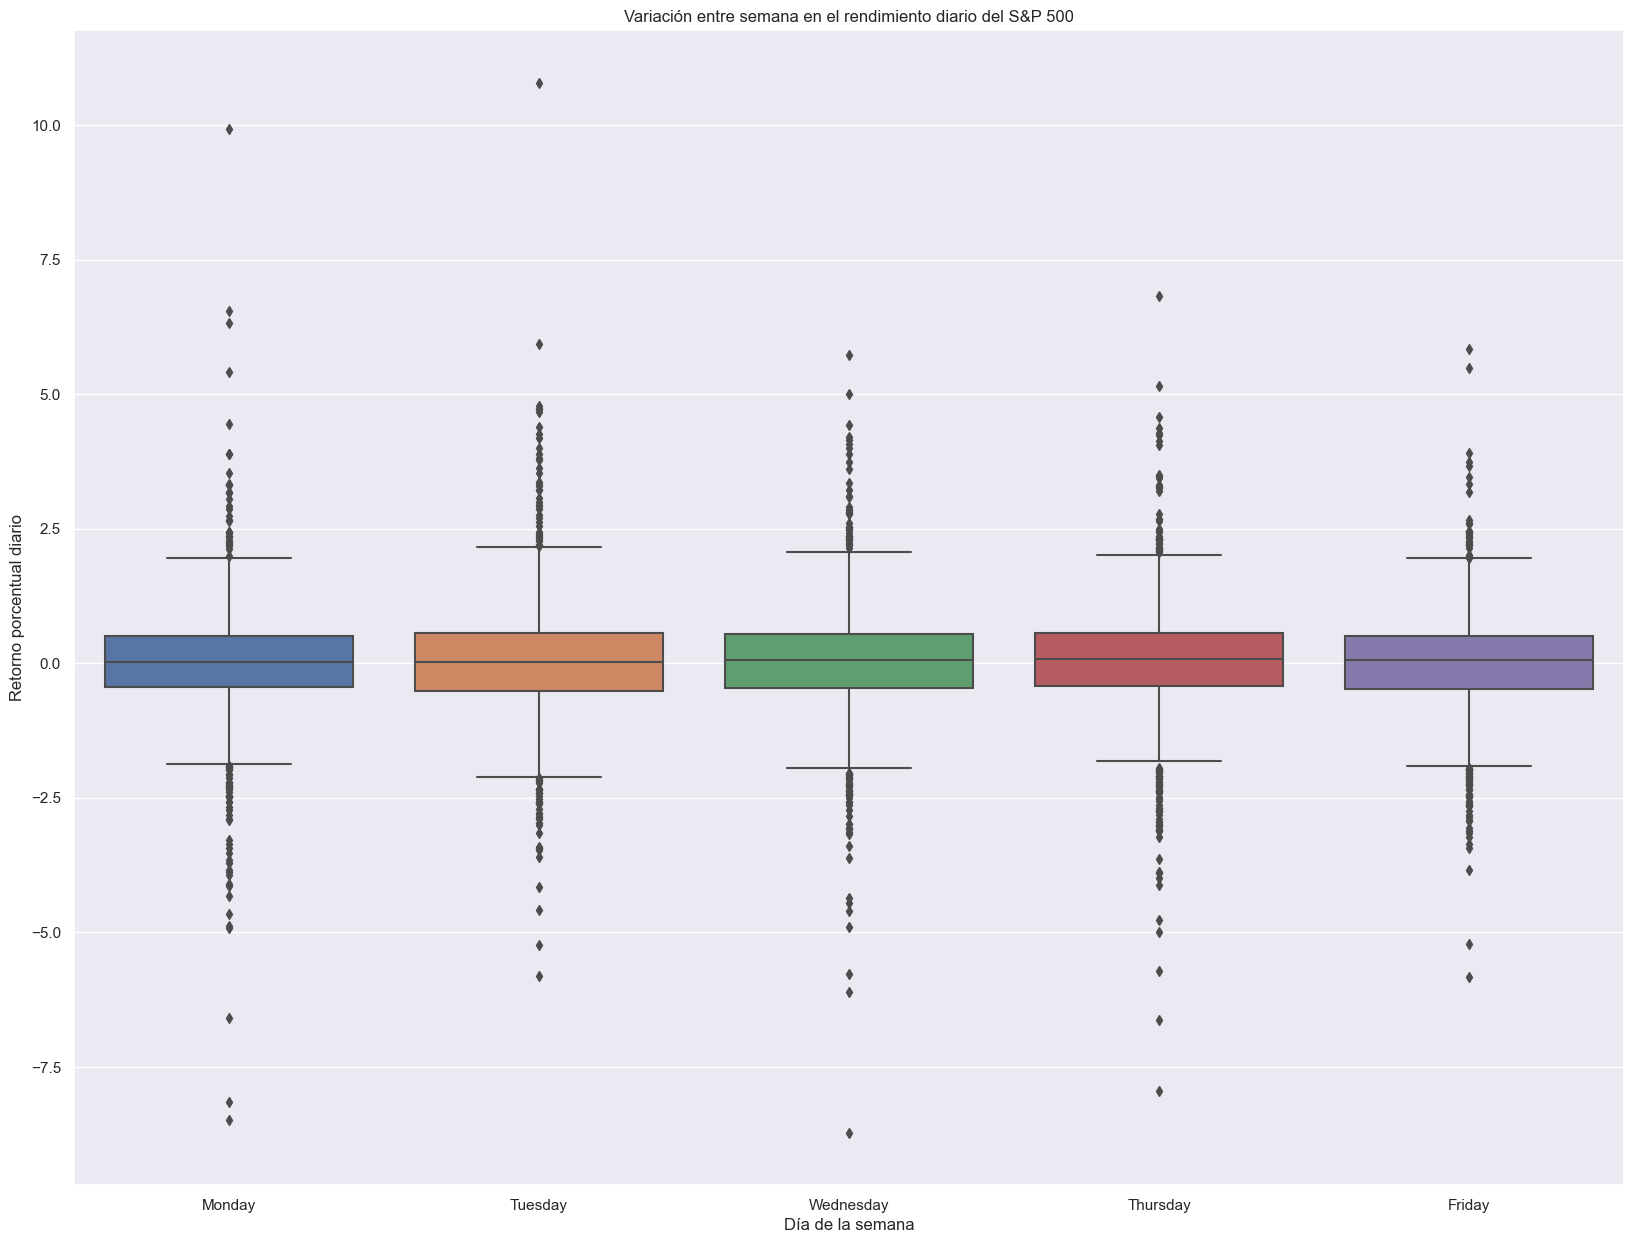

In [ ]:
# box plot para cada mes que muestra cambios porcentuales por día
index_dy = ['Monday','Tuesday','Wednesday','Thursday','Friday'] # Reordenar índice
sns.set(rc = {'figure.figsize':(20,15)}) #Establecer tamaño de figura
sns.boxplot(x='D_nm',y='P_day', data =data, order = index_dy)

plt.title("Variación entre semana en el rendimiento diario del S&P 500")
plt.xlabel("Día de la semana")
plt.ylabel("Retorno porcentual diario")

Text(0, 0.5, 'Retorno porcentual diario')

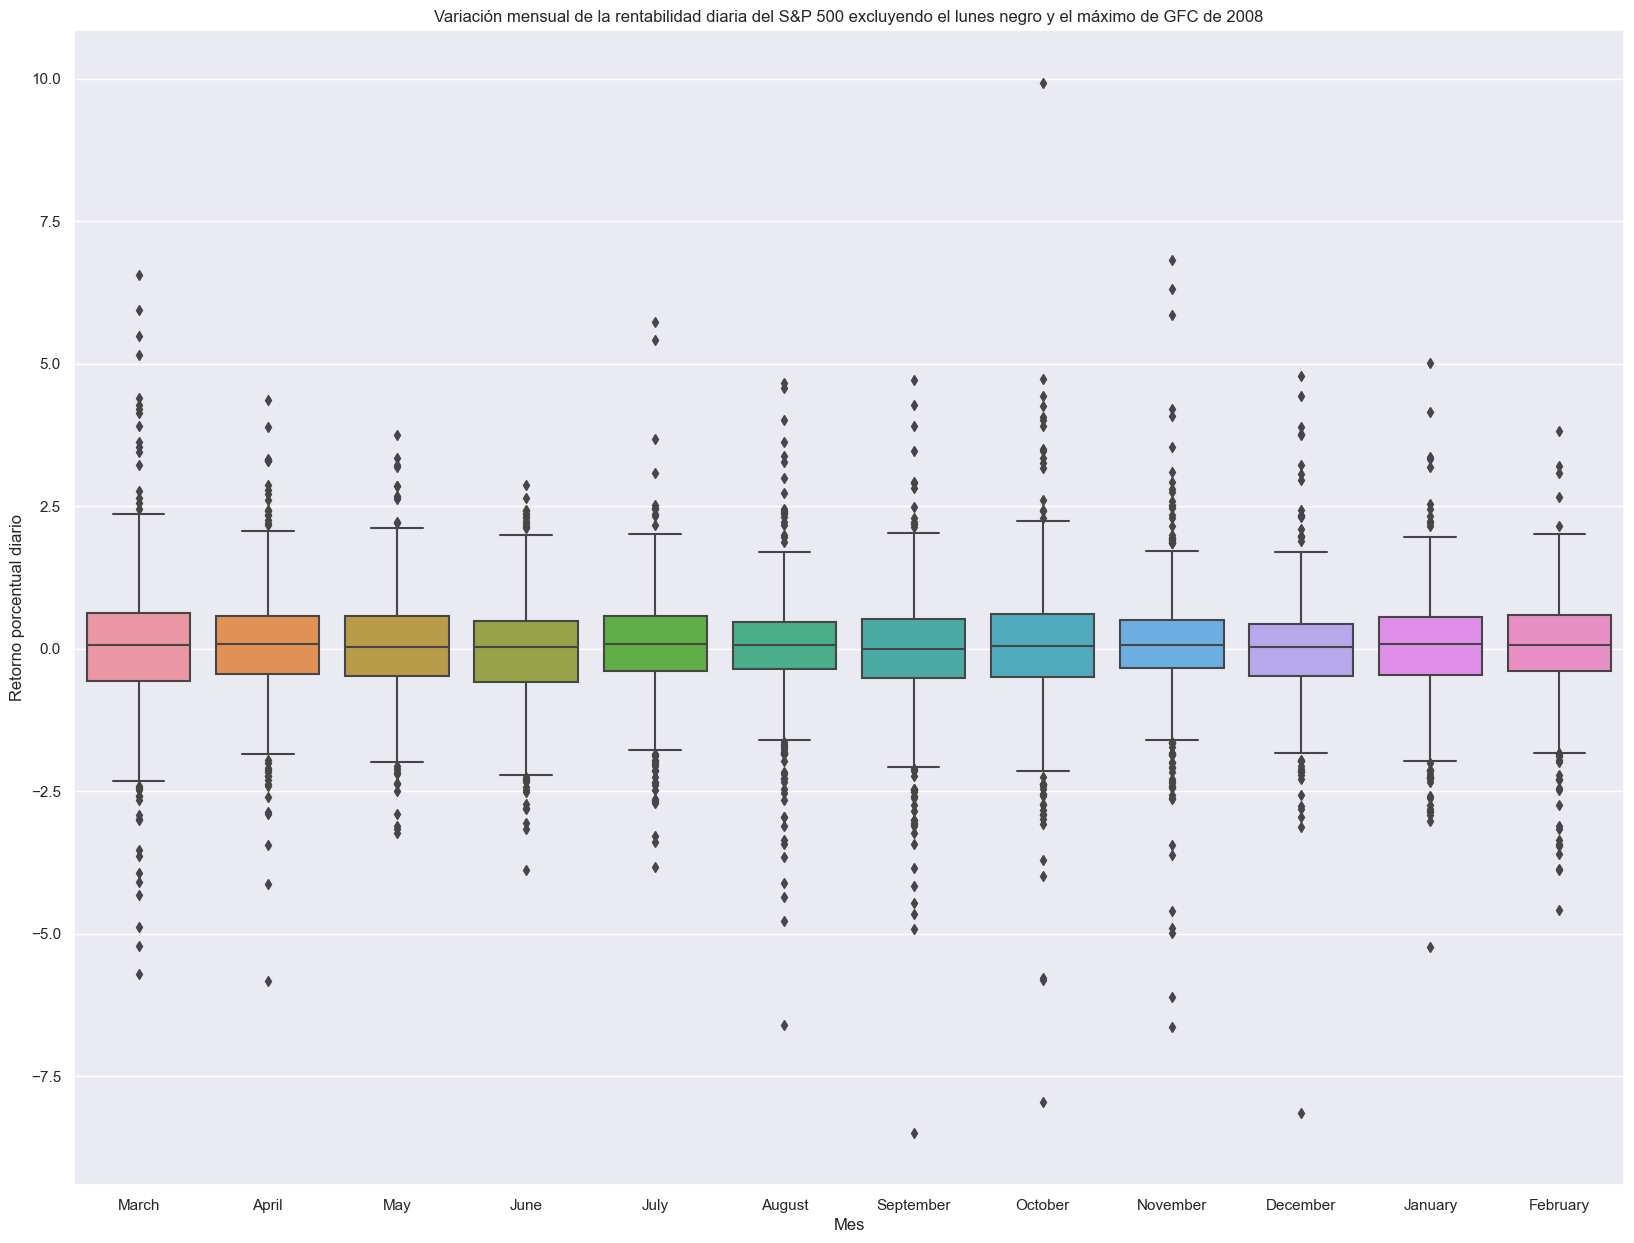

In [ ]:
# Remueve Black Friday y Datos de GFC de 2008 de mnth_df
# encuentra el valor del índice tanto para el máximo como para el mínimo de octubre
mth_max = data[(data['P_day'] == data['P_day'].max()) & (data['M_nm'] == "October")].index[0]
mth_min =data[(data['P_day'] == data['P_day'].min()) & (data['M_nm'] == "October")].index[0]

data2 = data.drop(labels = [mth_min, mth_max], axis = 0)

# box plot para cada mes que muestra cambios porcentuales por día
sns.set(rc = {'figure.figsize':(20,15)}) 

sns.boxplot(x='M_nm',y='P_day', data =data2)
plt.title("Variación mensual de la rentabilidad diaria del S&P 500 excluyendo el lunes negro y el máximo de GFC de 2008")
plt.xlabel("Mes")
plt.ylabel("Retorno porcentual diario")

Text(0, 0.5, 'Retorno porcentual diario')

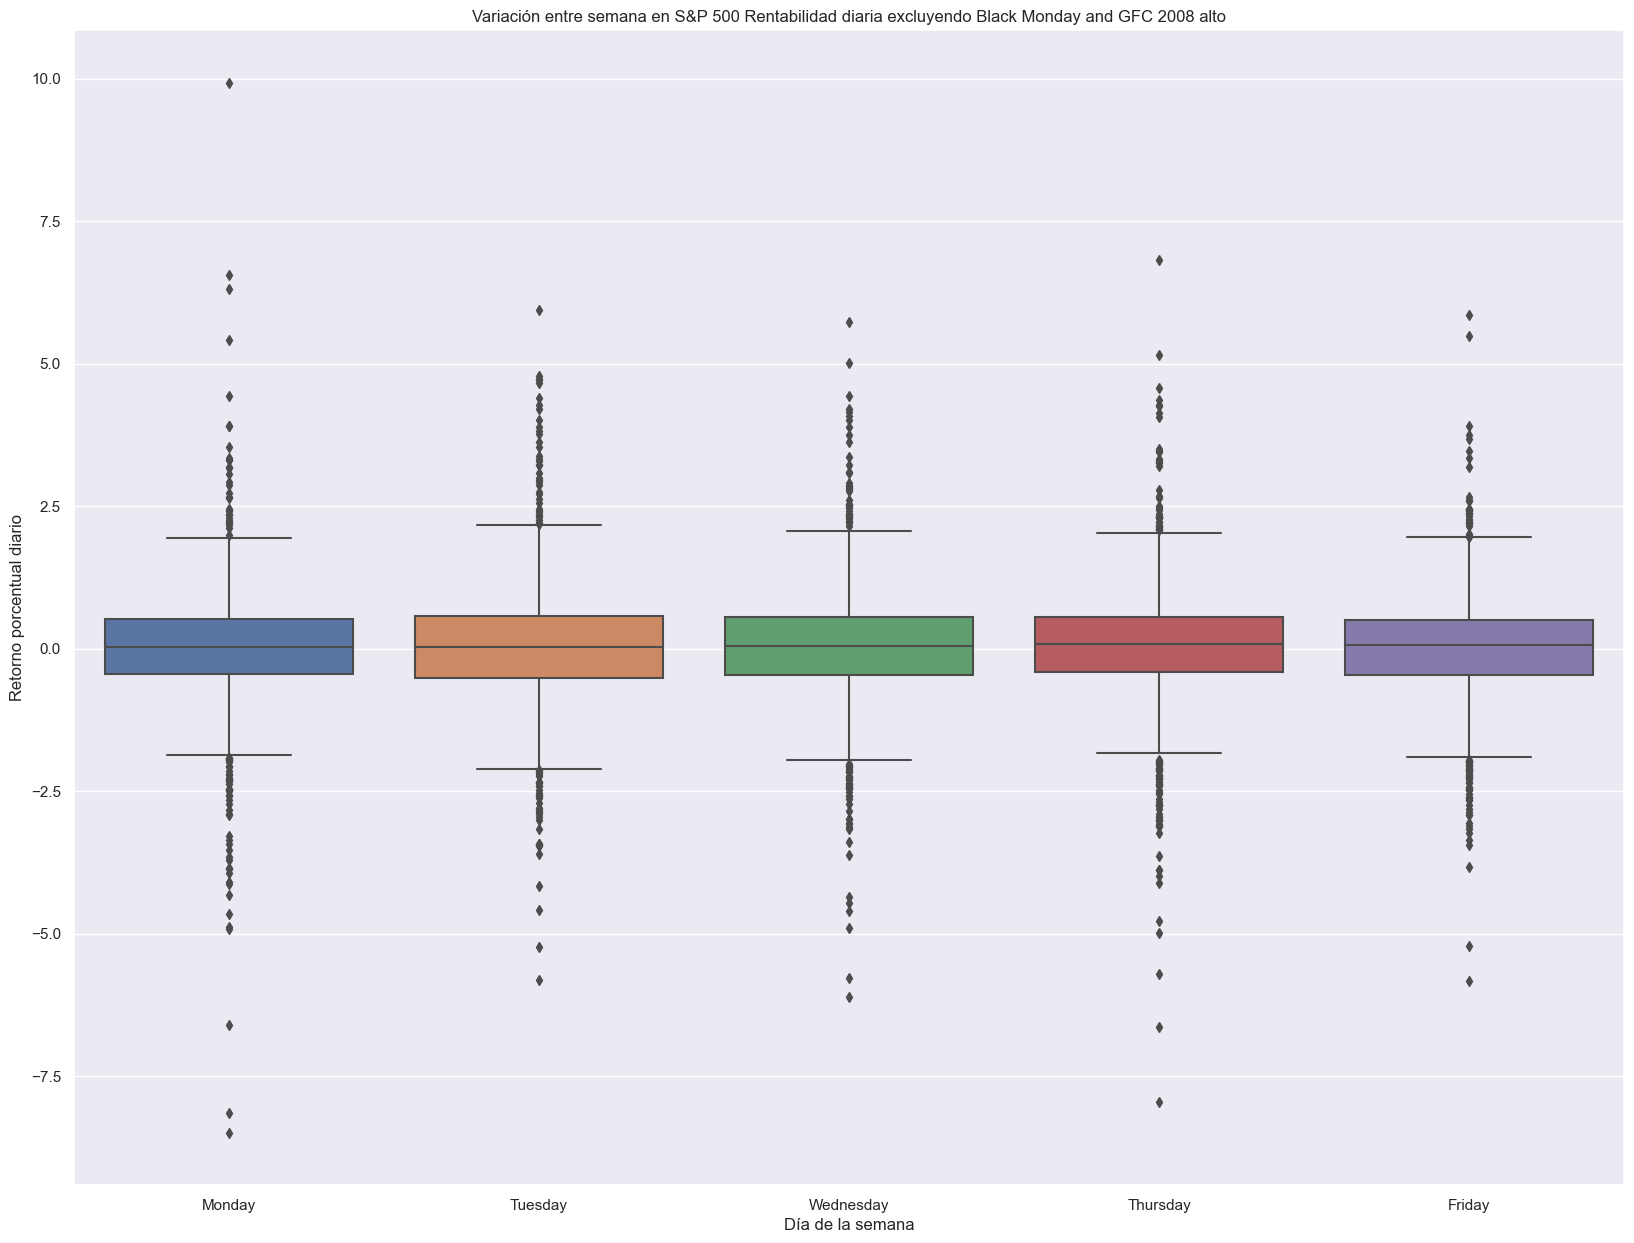

In [ ]:
# box plot para cada mes que muestra cambios porcentuales por día
index_dy = ['Monday','Tuesday','Wednesday','Thursday','Friday'] # Reorder index
sns.set(rc = {'figure.figsize':(20,15)}) #Set figure size
sns.boxplot(x='D_nm',y='P_day', data =data2, order = index_dy)

plt.title("Variación entre semana en S&P 500 Rentabilidad diaria excluyendo Black Monday and GFC 2008")
plt.xlabel("Día de la semana")
plt.ylabel("Retorno porcentual diario")

El mes de octubre tiene el cambio diario porcentual más alto y más bajo y también tiene el promedio y la desviación estándar más amplios. El valor más bajo de -20,47 % se produjo el [Black Monday](https://www.federalreservehistory.org/essays/stock-market-crash-of-1987) y su valor más alto se produjo durante la [2008 Global Financial Crisis](https://www.federalreservehistory.org/essays/great-recession-and-its-aftermath). Incluso cuando se eliminan estos dos valores (como se muestra arriba), octubre todavía produce cambios porcentuales diarios que son más altos y más bajos que los otros meses, aunque están más alineados.

<a id="Summary"></a>
# Resumen

Con base en el análisis anterior, podemos concluir lo siguiente:

1) **Octubre** es el mes más volátil, con el mayor aumento y disminución diarios de precios. Tenga en cuenta que, incluso después de eliminar las mayores oscilaciones de precios, la variación diaria de precios de octubre sigue estando significativamente por encima de los meses restantes. Octubre es el único mes con una variación diaria de precios superior al 1%.

2) **Lunes** es el día más volátil, teniendo la mayor variación diaria de precios. Esto podría deberse a que los eventos que ocurrieron después del cierre del viernes y durante todo el fin de semana se cotizaron en el mercado el lunes.

3) Se producen grandes aumentos de precios en torno a **descensos/disturbios del mercado**. Siete (7) de los diez (10) precios porcentuales diarios más altos se produjeron durante la GFC de 2008.

4) **El rendimiento de la semana n.º 1** es un indicador decente de cómo se comportará el S&P500 durante el resto del año. Cuanto mayor sea la ganancia/disminución semanal, es más probable que el rendimiento anual siga la misma tendencia.

5) Los grandes movimientos diarios de precios con movimientos de precios son raros. Los movimientos diarios de precios de **mayores o iguales al 1%** ocurren menos del 5% del tiempo. Sin embargo, las rentabilidades anuales han sido positivas en el **71 %** de los años. Se han producido rendimientos anuales superiores al 6 % (rendimiento de la tesorería a 30 años en 2000 - ganancias libres de riesgo) **60 %** del tiempo.

6) La única década que no produjo un aumento de precios fue la década de 2000, que comenzó con la burbuja tecnológica de 2000 y terminó con la crisis financiera mundial de 2008. Cada dos décadas ha producido un retorno positivo. **Vale la pena permanecer en el mercado a largo plazo.**